When to run:
- After running the datalog engine and the csv files have been created (CCTX_Withdrawals.csv and CCTX_Deposits.csv)

Functionality:
- Calculates the value in USD transacted in each cross-chain transaction
- Calculates the time difference between transactions in each chain pertaining to the same cross-chain transaction

In [2]:
BRIDGE_NAME = "nomad-bridge"

MAP_SRC_DST_TOKENS = {
    "0xba8d75baccc4d5c4bd814fde69267213052ea663": "0xacc15dc74880c9944775448304b263d191c6077f", #WGLMR
    "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48": "0x8f552a71efe5eefc207bf75485b356a0b3f01ec9", #USDC
    "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2": "0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7", #WETH
    "0x2260fac5e5542a773aa44fbcfedf7c193bc2c599": "0x1dc78acda13a8bc4408b207c9e48cdbc096d95e0", #WBTC
    "0x6b175474e89094c44da98b954eedeac495271d0f": "0xc234a67a4f840e61ade794be47de455361b52413", #DAI 
    "0xdac17f958d2ee523a2206206994597c13d831ec7": "0x8e70cd5b4ff3f62659049e74b6649c6603a0e594", #USDT
    "0xd417144312dbf50465b1c641d016962017ef6240": "0x5130ca61bf02618548dfc3fdef50b50b36b11f2b", #CQT
    "0x853d955acef822db058eb8505911ed77f175b99e": "0x8d6e233106733c7cc1ba962f8de9e4dcd3b0308e", #FRAX
    "0x0bf0d26a527384bcc4072a6e2bca3fc79e49fa2d": "0xf42bd09c48498afa3993c00e226e97841d5789a7", #MYT
    "0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0": "0x21a8daca6a56434bdb6f39e7616c0f9891829aec", #FXS
}

MAP_TOKEN_TO_ID = {
    "0xacc15dc74880c9944775448304b263d191c6077f": "moonbeam",
    "0x8f552a71efe5eefc207bf75485b356a0b3f01ec9": "usdc",
    "0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7": "weth",
    "0x1dc78acda13a8bc4408b207c9e48cdbc096d95e0": "wrapped-bitcoin",
    "0xc234a67a4f840e61ade794be47de455361b52413": "dai",
    "0x8e70cd5b4ff3f62659049e74b6649c6603a0e594": "tether-usdt",
    "0x5130ca61bf02618548dfc3fdef50b50b36b11f2b": "covalent",
    "0x8d6e233106733c7cc1ba962f8de9e4dcd3b0308e": "frax",
    "0xf42bd09c48498afa3993c00e226e97841d5789a7": "none",   # cannot retreive the price of this token, but it is always around 0.00000XXX, so we will just consider 0
    "0x21a8daca6a56434bdb6f39e7616c0f9891829aec": "frax-share",
    "0x40eb746dee876ac1e78697b7ca85142d178a1fc8": "iagon",
}

MAP_TOKEN_TO_DECIMALS = {
    "0xacc15dc74880c9944775448304b263d191c6077f": 18,
    "0x8f552a71efe5eefc207bf75485b356a0b3f01ec9": 6,
    "0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7": 18,
    "0x1dc78acda13a8bc4408b207c9e48cdbc096d95e0": 8,
    "0xc234a67a4f840e61ade794be47de455361b52413": 18,
    "0x8e70cd5b4ff3f62659049e74b6649c6603a0e594": 6,
    "0x5130ca61bf02618548dfc3fdef50b50b36b11f2b": 18,
    "0x8d6e233106733c7cc1ba962f8de9e4dcd3b0308e": 18,
    "0xf42bd09c48498afa3993c00e226e97841d5789a7": 0,
    "0x21a8daca6a56434bdb6f39e7616c0f9891829aec": 18,
    "0x40eb746dee876ac1e78697b7ca85142d178a1fc8": 18,
}

In [2]:
pip install pandas matplotlib python-dotenv requests;


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import pandas as pd

# overwrite the existing file
def create_latex_file(bridge_name):
    with open(f'./{bridge_name}/latex/datalog-results.tex', 'w') as file:
        file.write("")

def format_rule_name(rule_name):
    rule_name = rule_name.replace("_", "")
    rule_name = rule_name.replace("20", "")
    return rule_name

def extractBridgeName(bridge_name):
    bridge = bridge_name.split('-')[0]
    return bridge[0].upper() + bridge[1:]

def add_metrics_to_latex_file(bridge_name, rule, value):
    rule = format_rule_name(rule) + extractBridgeName(bridge_name)

    with open(f'./{bridge_name}/latex/datalog-results.tex', 'a') as file:
        line = "\\newcommand{\\" + rule + "}{" + str(value) + "~}"
        file.write(line + '\n')

create_latex_file(BRIDGE_NAME)

In [7]:
# Add to the data frame the value being transferred in USD, based on the price of the token at that date
def calculateTxValueInUSD(token_address, value, day):

    try:
        token_id = MAP_TOKEN_TO_ID[token_address]
    except Exception:
        return np.nan

    if token_id == "none":
        return np.nan
    
    df_token_price = pd.read_csv(f"../../data/{BRIDGE_NAME}/token_prices/{token_id}_historical_data.csv")

    try:
        price = df_token_price[df_token_price['date'] == day].iloc[0]['price']
        tx_volume = int(value) / (10**(MAP_TOKEN_TO_DECIMALS[token_address])) * price
        return tx_volume
    except KeyError:
        raise KeyError(f"The key '{token_address}' was not present in token the dictionary.")

In [8]:
def addTransactionTimeDifferencesToDataframe(cctxs, time_interval_days):
    # Calculate time differences
    cctxs['time_difference'] = pd.to_numeric(cctxs.iloc[:, 4], errors='coerce') - pd.to_numeric(cctxs.iloc[:, 1], errors='coerce')

    # # Convert Unix timestamps to datetime objects
    # cctxs.iloc[:, 1] = pd.to_numeric(cctxs.iloc[:, 1])
    # cctxs.iloc[:, 4] = pd.to_numeric(cctxs.iloc[:, 4])

    print("NUMBER OF DATAPOINTS:", len(cctxs['time_difference']))
    print("MAX CCTX LATENCY:", max(cctxs['time_difference']))
    print("MIN CCTX LATENCY:", min(cctxs['time_difference']))
    print("AVG CCTX LATENCY:", sum(cctxs['time_difference'])/len(cctxs['time_difference']))
    print("AVG CCTX LATENCY (MINS):", sum(cctxs['time_difference'])/len(cctxs['time_difference'])/60)
    print("AVG CCTX LATENCY (HOURS):", sum(cctxs['time_difference'])/len(cctxs['time_difference'])/60/60)
    print("AVG CCTX LATENCY (DAYS):", sum(cctxs['time_difference'])/len(cctxs['time_difference'])/60/60/24)
    std_dev = cctxs['time_difference'].std()
    print("Standard Deviation of CCTX Latency:", std_dev)

    # Round hour to the nearest multiple of time_interval_days (e.g., 15 represents periods of 15 days)
    cctxs['day_rounded'] = (pd.to_datetime(cctxs.iloc[:, 1], unit='s').dt.day // time_interval_days) * time_interval_days

    # Create a new column combining year, month, day, and rounded hour
    cctxs['datetime_group'] = pd.to_datetime(cctxs.iloc[:, 1], unit='s').dt.strftime('%Y-%m-') + cctxs['day_rounded'].astype(str).str.zfill(2) + " 00:00"

    return cctxs

In [9]:
def plotTimeDifferencesBoxplot(cctxs, logScale, title):
    ax = cctxs.boxplot(column='time_difference', by='datetime_group', grid=True)

    plt.suptitle('')
    plt.xticks(rotation=90)
    ax.set_title(title)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Time Difference (seconds)')
    if logScale:
        ax.set_yscale('log')
    plt.show()

In [10]:
def plotScatterPlot(cctxs, action):
    plt.figure(figsize=(10, 6))
    plt.scatter(cctxs['time_difference'], cctxs['value_usd'], color='blue', alpha=0.5)
    plt.title(f'Correlation of CCTX Latency and Value Transferred for CCTX {action}')
    plt.xlabel('CCTX Latency (s)')
    plt.ylabel('Value (USD)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(10**1, 10**8)
    plt.grid(True)

# Analysis on the data of the selected interval

## CCTX Deposits

In [8]:
# Calculate USD value for each cctx

cctxs_deposits = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Deposit.csv", header=None, sep='\t')
cctxs_deposits["value_usd"] = None

for index, row in cctxs_deposits.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[8], row.loc[11], day)
    cctxs_deposits.at[index, "value_usd"] = tx_volume

In [9]:
print(f"Total Value Deposited in USD: ${cctxs_deposits['value_usd'].sum():.2f}")
print(f"Total Value Deposited in Million USD: ${cctxs_deposits['value_usd'].sum() / 10**6:.2f}M")

Total Value Deposited in USD: $365707460.17
Total Value Deposited in Million USD: $365.71M


In [10]:
addTransactionTimeDifferencesToDataframe(cctxs_deposits, 7).head()
cctxs_deposits.rename(columns={0: 'orig_chain_id', 1: 'orig_timestamp', 2: 'orig_tx_hash', 3: 'dst_chain_id', 4: 'dst_timestamp', 5: 'dst_tx_hash', 6: 'deposit_id', 7: 'origin_token', 8: 'dst_token', 9: 'sender', 10: 'beneficiary', 11: 'amount'}, inplace=True)
cctxs_deposits.to_csv(f'./{BRIDGE_NAME}/data/cctxs_deposits.csv', index=False)

NUMBER OF DATAPOINTS: 11404
MAX CCTX LATENCY: 10618947
MIN CCTX LATENCY: 1875
AVG CCTX LATENCY: 89143.005787443
AVG CCTX LATENCY (MINS): 1485.7167631240502
AVG CCTX LATENCY (HOURS): 24.761946052067504
AVG CCTX LATENCY (DAYS): 1.0317477521694793
Standard Deviation of CCTX Latency: 923976.9677438365


Correlation between Latency and Value transferred: -0.014361708527784687


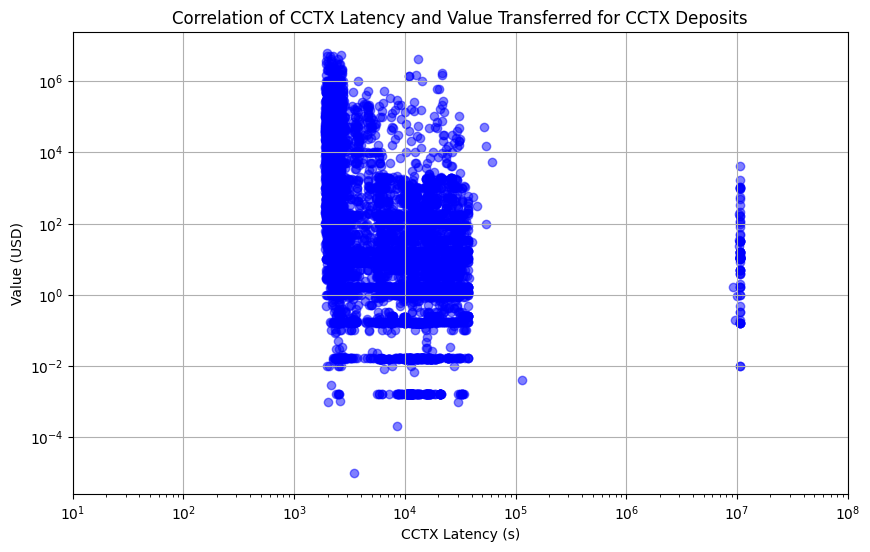

In [11]:
correlation = cctxs_deposits['time_difference'].corr(cctxs_deposits['value_usd'])
print("Correlation between Latency and Value transferred:", correlation)

plotScatterPlot(cctxs_deposits, "Deposits")

NUMBER OF DATAPOINTS: 10417
MAX CCTX LATENCY: 60938
MIN CCTX LATENCY: 1875
AVG CCTX LATENCY: 8016.9064989920325
AVG CCTX LATENCY (MINS): 133.61510831653388
AVG CCTX LATENCY (HOURS): 2.2269184719422315
AVG CCTX LATENCY (DAYS): 0.09278826966425964
MEDIAN CCTX LATENCY: 2579.0
Standard Deviation of CCTX Latency: 8782.651552089468
Total Value Deposited in USD (before attack): $363810247.79
Total Value Deposited in USD (before attack): $363.81


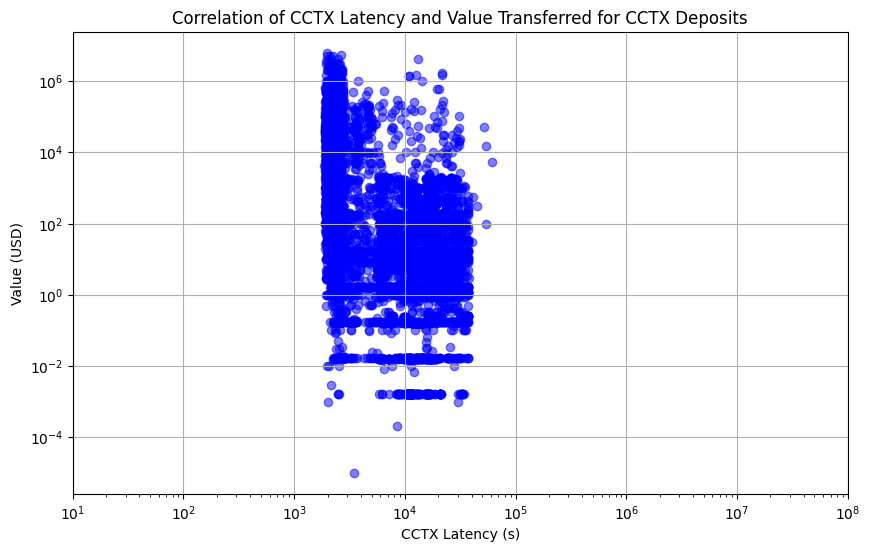

In [12]:
# cctxs_deposits_before_attack contains the CCTXs before the attack on the 2022-08-01
cctxs_deposits_before_attack = cctxs_deposits[cctxs_deposits['dst_timestamp'] < 1659308400]

# calculate size, min, max, mean, median, and standard deviation of the time_difference column
print("NUMBER OF DATAPOINTS:", len(cctxs_deposits_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "size_cctx_deposits_latency", len(cctxs_deposits_before_attack['time_difference']))

print("MAX CCTX LATENCY:", max(cctxs_deposits_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "max_cctx_deposits_latency", "{:,.2f}".format(max(cctxs_deposits_before_attack['time_difference'])))

print("MIN CCTX LATENCY:", min(cctxs_deposits_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "min_cctx_deposits_latency", "{:,.2f}".format(min(cctxs_deposits_before_attack['time_difference'])))

print("AVG CCTX LATENCY:", sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "avg_cctx_deposits_latency", "{:,.2f}".format(sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference'])))

print("AVG CCTX LATENCY (MINS):", sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference'])/60)
print("AVG CCTX LATENCY (HOURS):", sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference'])/60/60)
print("AVG CCTX LATENCY (DAYS):", sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference'])/60/60/24)

print("MEDIAN CCTX LATENCY:", cctxs_deposits_before_attack['time_difference'].median())
add_metrics_to_latex_file(BRIDGE_NAME, "median_cctx_deposits_latency", "{:,.2f}".format(cctxs_deposits_before_attack['time_difference'].median()))

std_dev = cctxs_deposits_before_attack['time_difference'].std()
print("Standard Deviation of CCTX Latency:", std_dev)
add_metrics_to_latex_file(BRIDGE_NAME, "std_cctx_deposits_latency", "{:,.2f}".format(std_dev))

total_value = cctxs_deposits_before_attack['value_usd'].sum()
print(f"Total Value Deposited in USD (before attack): ${total_value:.2f}")
print(f"Total Value Deposited in USD (before attack): ${total_value/10**6:.2f}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_value_deposits_before_attack", "{:,.2f}".format(total_value/10**6))

plotScatterPlot(cctxs_deposits_before_attack, "Deposits")

In [18]:
cctxs_deposits_finality_break = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Deposit_FinalityBreak.csv", header=None, sep='\t')
cctxs_deposits_finality_break["value_usd"] = None

for index, row in cctxs_deposits_finality_break.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[8], row.loc[11], day)
    cctxs_deposits_finality_break.at[index, "value_usd"] = tx_volume

cctxs_deposits_finality_break = addTransactionTimeDifferencesToDataframe(cctxs_deposits_finality_break, 7)
# merge cctxs_deposits_finality_break with cctxs_deposits
merged = pd.concat([cctxs_deposits, cctxs_deposits_finality_break])
merged.to_csv(f'./{BRIDGE_NAME}/data/cctxs_deposits-with-finality-break.csv', index=False)

NUMBER OF DATAPOINTS: 5
MAX CCTX LATENCY: 235
MIN CCTX LATENCY: 87
AVG CCTX LATENCY: 140.8
AVG CCTX LATENCY (MINS): 2.3466666666666667
AVG CCTX LATENCY (HOURS): 0.03911111111111111
AVG CCTX LATENCY (DAYS): 0.0016296296296296295
Standard Deviation of CCTX Latency: 58.4011986178366


Correlation between Latency and Value transferred: -0.014355118072936468


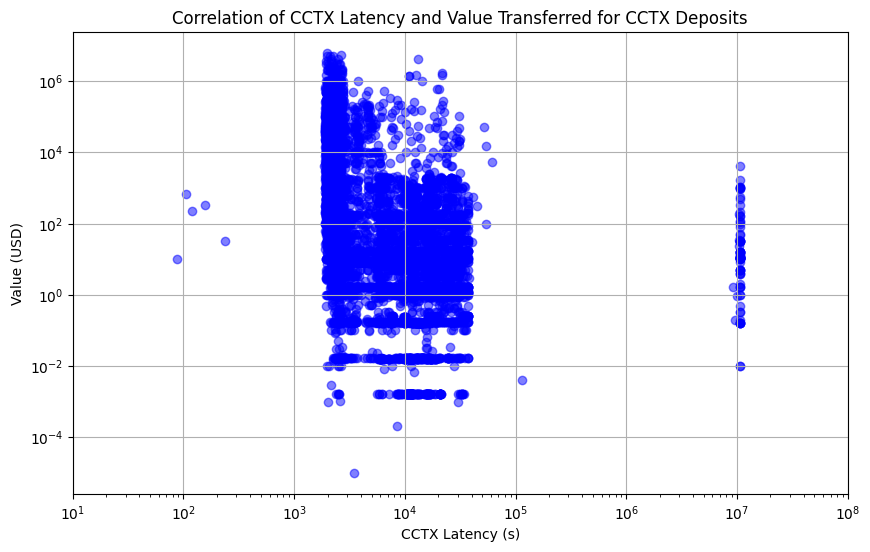

In [17]:
import matplotlib.patches as patches

correlation = merged['time_difference'].corr(merged['value_usd'])
print("Correlation between Latency and Value transferred:", correlation)

plotScatterPlot(merged, "Deposits")

Há 5 txs cujo diff é menor que 30 minutos, contrariamente ao que diz nos [docs](https://docs.nomad.xyz/the-nomad-protocol/security/root-of-trust/fraud/optimistic-timeout-period)

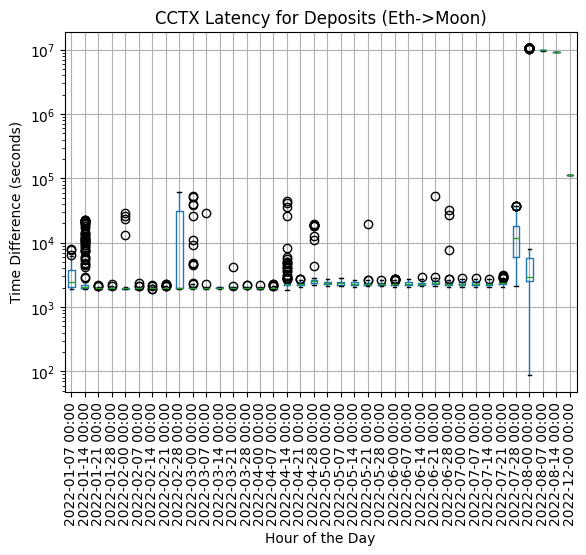

In [188]:
plotTimeDifferencesBoxplot(cctxs_deposits, True, "CCTX Latency for Deposits (Eth->Moon)")

## CCTX Withdrawal

In [13]:
cctxs_withdrawal = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Withdrawal.csv", header=None, sep='\t')
cctxs_withdrawal["value_usd"] = None

for index, row in cctxs_withdrawal.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    cctxs_withdrawal.at[index, "value_usd"] = tx_volume

In [14]:
print(f"Total Value Withdrawn in USD: ${cctxs_withdrawal['value_usd'].sum():.2f}")
print(f"Total Value Withdrawn in Million USD: ${cctxs_withdrawal['value_usd'].sum() / 10**6:.2f}M")

Total Value Withdrawn in USD: $222160612.50
Total Value Withdrawn in Million USD: $222.16M


In [15]:
addTransactionTimeDifferencesToDataframe(cctxs_withdrawal, 7).head()
cctxs_withdrawal.rename(columns={0: 'orig_chain_id', 1: 'orig_timestamp', 2: 'orig_tx_hash', 3: 'dst_chain_id', 4: 'dst_timestamp', 5: 'dst_tx_hash', 6: 'withdrawal_id', 7: 'origin_token', 8: 'dst_token', 9: 'sender', 10: 'beneficiary', 11: 'amount'}, inplace=True)
cctxs_withdrawal.to_csv(f'./{BRIDGE_NAME}/data/cctxs_withdrawals.csv', index=False)

NUMBER OF DATAPOINTS: 4482
MAX CCTX LATENCY: 13708549
MIN CCTX LATENCY: 1860
AVG CCTX LATENCY: 186331.0339134315
AVG CCTX LATENCY (MINS): 3105.517231890525
AVG CCTX LATENCY (HOURS): 51.758620531508754
AVG CCTX LATENCY (DAYS): 2.156609188812865
Standard Deviation of CCTX Latency: 889628.852040383


Correlation between Latency and Value transferred: -0.0223233132688836


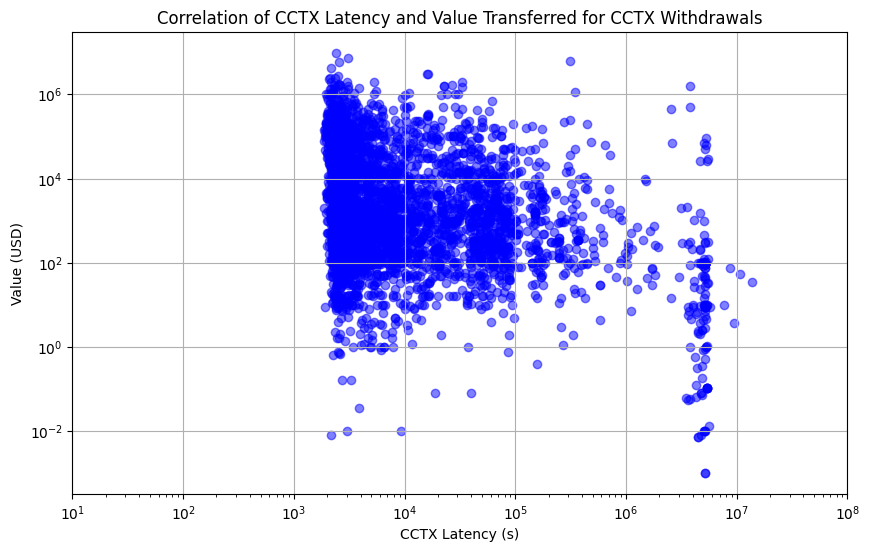

In [16]:
correlation = cctxs_withdrawal['time_difference'].corr(cctxs_withdrawal['value_usd'])
print("Correlation between Latency and Value transferred:", correlation)

plotScatterPlot(cctxs_withdrawal, "Withdrawals")

NUMBER OF DATAPOINTS: 4286
MAX CCTX LATENCY: 13708549
MIN CCTX LATENCY: 1860
AVG CCTX LATENCY: 193614.49090060662
AVG CCTX LATENCY (MINS): 3226.908181676777
AVG CCTX LATENCY (HOURS): 53.78180302794628
AVG CCTX LATENCY (DAYS): 2.2409084594977617
MEDIAN CCTX LATENCY: 4556.0
Standard Deviation of CCTX Latency: 909019.0222242338
Total Value Withdrawn in USD (before attack): $221502617.09
Total Value Withdrawn in USD (before attack): $221.50


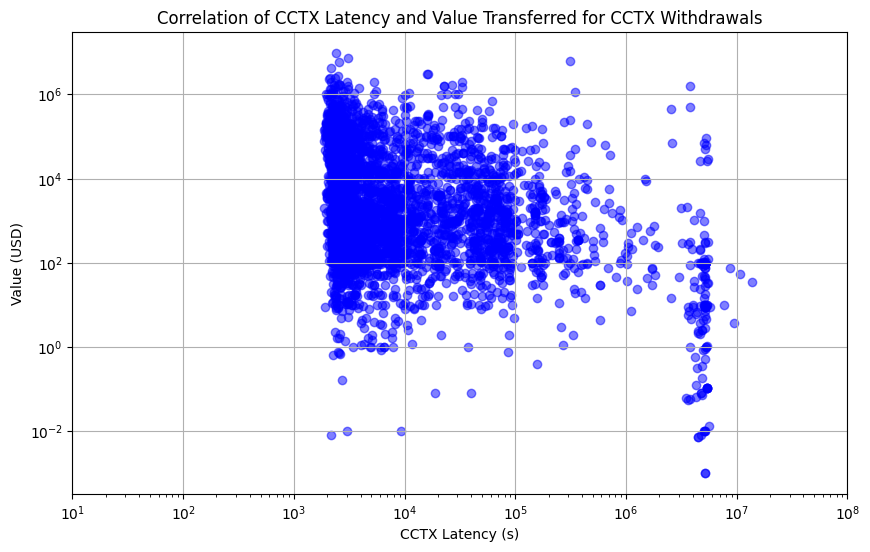

In [17]:
# cctxs_withdrawals_before_attack contains the CCTXs before the attack on the 2022-08-01
cctxs_withdrawals_before_attack = cctxs_withdrawal[cctxs_withdrawal['dst_timestamp'] < 1659308400]

# calculate size, min, max, mean, median, and standard deviation of the time_difference column
print("NUMBER OF DATAPOINTS:", len(cctxs_withdrawals_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "size_cctx_withdrawals_latency", len(cctxs_withdrawals_before_attack['time_difference']))

print("MAX CCTX LATENCY:", max(cctxs_withdrawals_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "max_cctx_withdrawals_latency",  "{:,.2f}".format(max(cctxs_withdrawals_before_attack['time_difference'])))

print("MIN CCTX LATENCY:", min(cctxs_withdrawals_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "min_cctx_withdrawals_latency",  "{:,.2f}".format(min(cctxs_withdrawals_before_attack['time_difference'])))

print("AVG CCTX LATENCY:", sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "avg_cctx_withdrawals_latency", "{:,.2f}".format(sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference'])))

print("AVG CCTX LATENCY (MINS):", sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference'])/60)
print("AVG CCTX LATENCY (HOURS):", sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference'])/60/60)
print("AVG CCTX LATENCY (DAYS):", sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference'])/60/60/24)

print("MEDIAN CCTX LATENCY:", cctxs_withdrawals_before_attack['time_difference'].median())
add_metrics_to_latex_file(BRIDGE_NAME, "median_cctx_withdrawals_latency", "{:,.2f}".format(cctxs_withdrawals_before_attack['time_difference'].median()))

std_dev = cctxs_withdrawals_before_attack['time_difference'].std()
print("Standard Deviation of CCTX Latency:", std_dev)

add_metrics_to_latex_file(BRIDGE_NAME, "std_cctx_withdrawals_latency", "{:,.2f}".format(std_dev))


total_value = cctxs_withdrawals_before_attack['value_usd'].sum()
print(f"Total Value Withdrawn in USD (before attack): ${total_value:.2f}")
print(f"Total Value Withdrawn in USD (before attack): ${total_value/10**6:.2f}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_value_withdrawals_before_attack", "{:,.2f}".format(total_value/10**6))

plotScatterPlot(cctxs_withdrawals_before_attack, "Withdrawals")

**Notes to add in the paper:**
The amount of time it takes for transactions to complete does not seem to affect the transaction value in a linear way -- i.e., higher value transactions do not necessarily take longer time to process.
Actually, the plot shows that the whole range of transferred values swipe the entire plot across all possible latencies of cross-chain transactions.

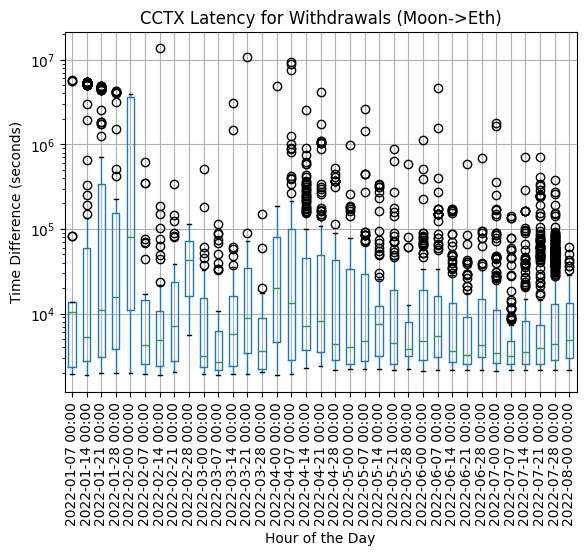

In [193]:
plotTimeDifferencesBoxplot(cctxs_withdrawal, True, "CCTX Latency for Withdrawals (Moon->Eth)")

This variability in the latency of cctxs from Ronin->Ethereum is explained by:
- the users need to perform the final transfer to Ethereum such that the bridge operator does not have to pay for the gas fees
- some users to not have funds in their address in Ethereum, therefore delay the final withdrawal on Ethereum

# MERGE DATAFRAMES

In [420]:
# Add a source column to each DataFrame
cctxs_deposits.rename(columns={"deposit_id": "action_id"}, inplace=True)
cctxs_withdrawal.rename(columns={"withdrawal_id": "action_id"}, inplace=True)

cctxs_deposits['action'] = 'deposit'
cctxs_withdrawal['action'] = 'withdrawal'


combined_cctxs = pd.concat([cctxs_deposits, cctxs_withdrawal])
combined_cctxs.to_csv(f'./{BRIDGE_NAME}/data/combined_cctxs.csv', index=False)

11404
4482
15886


### Unmatched SC_ValidERC20TokenDeposited

In [407]:
deposited = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/SC_DepositsWithoutMatch.csv", header=None, sep='\t')
deposited["value_usd"] = None

deposited["date"] = pd.to_datetime(deposited.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in deposited.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[6], row.loc[9], day)
    deposited.at[index, "value_usd"] = tx_volume

print(len(deposited))
deposited.head()

6


,0,1,2,3,4,5,6,7,8,9,value_usd,date
0,6648936,1659390036,0xe0bcb77e9a5375a345a277c64b548cb0e938270ce47e...,1650811245,11335,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x1dc78acda13a8bc4408b207c9e48cdbc096d95e0,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,1000000,229.708588,2022-08-01 21:40
1,6648936,1659390560,0xd98b01025801b3a8c456b14e11b84a700b116b4e4804...,1650811245,11337,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x1dc78acda13a8bc4408b207c9e48cdbc096d95e0,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,3000000,689.125765,2022-08-01 21:49
2,6648936,1659391955,0xc1e73bbcb658cc006b11cd5536cdcc857ff91c3cec9a...,1650811245,11339,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,20000000000000000,32.766809,2022-08-01 22:12
3,6648936,1659392724,0x7a62b24ffc5ed580aca1fb2f2942a3f751d6115f82d1...,1650811245,11344,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,200000000000000000,327.668094,2022-08-01 22:25
4,6648936,1659393723,0xeb06aa1e251555ac1e4f58b04987d37f87cf407266a5...,1650811245,11350,0x6b175474e89094c44da98b954eedeac495271d0f,0xc234a67a4f840e61ade794be47de455361b52413,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,10000000000000000000,9.996744,2022-08-01 22:42


### Unmatched TC_ValidERC20TokenDeposited

In [408]:
deposited = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_DepositsWithoutMatch.csv", header=None, sep='\t')
deposited["value_usd"] = None

deposited["date"] = pd.to_datetime(deposited.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in deposited.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    try:
        tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[6], day)
        deposited.at[index, "value_usd"] = tx_volume
    except Exception as e:
        tx_volume = np.nan

print(len(deposited))
deposited.head()

13


,0,1,2,3,4,5,6,value_usd,date
0,1650811245,1651224792,0x3a5b7663d66c6d265d8d70081dc9d2dc5d85a97a5f73...,2164,0x8be1680d1ff72382f312ca3a207441043c8f9cec,0x4180e90db112047e588b1037db8ed8235c9e1382,200000000000000000000,NaN,2022-04-29 09:33
1,1650811245,1651308192,0x7fe7e6ea905831d135514fd665d9867349b24134f0dd...,2194,0x68a833447335c96d76d6f1aa8151c7e12ab5527e,0xbc65a184a8967880eed8900ca878c7dc49d2880b,1000000000000000000,NaN,2022-04-30 08:43
2,1650811245,1651335264,0x398d416d93d129f065f0b609160ffdfb36ae57b518ee...,2201,0xa742fafe323aab537aa5b38f6c5d421219161b81,0xbc65a184a8967880eed8900ca878c7dc49d2880b,2000000000000000000,NaN,2022-04-30 16:14
3,1650811245,1651335354,0x008f1c99e66186b0888f7c0318845075cc006967efc4...,2203,0xa742fafe323aab537aa5b38f6c5d421219161b81,0xbc65a184a8967880eed8900ca878c7dc49d2880b,2000000000000000000,NaN,2022-04-30 16:15
4,1650811245,1651335498,0xe539270c2d98212fab82546b467a91657b6de76af0a9...,2206,0xa742fafe323aab537aa5b38f6c5d421219161b81,0xbc65a184a8967880eed8900ca878c7dc49d2880b,28700000000000000000000000,NaN,2022-04-30 16:18


5 are the ones that do not follow the finality times. The others are explained bellow...

0x3a5b7663d66c6d265d8d70081dc9d2dc5d85a97a5f736336f4b62eea2d63dcd5. deploy token: 0x8bE1680D1FF72382F312Ca3a207441043c8f9Cec Eq in Ethereum: 0xD4949664CD82660AAE99BEDC034A0DEA8A0BD517     Token Ethereum: No name (11 txs total)
0x7fe7e6ea905831d135514fd665d9867349b24134f0dd1217fb7d55a88204bf27. deploy token: 0x68a833447335c96d76D6F1AA8151c7E12AB5527e Eq in Ethereum: 0x92C3A05B5CC7613E8A461968AD8616BAE3C47178     Token Ethereum: ERC-20: Wrapped GLMR (WGLMR) with 2 txs total
0x398d416d93d129f065f0b609160ffdfb36ae57b518eedcd8b8b5226c128453d7. Token: 0xa742fafe323AaB537AA5B38F6C5D421219161B81                                                                       Token Ethereum: ERC-20: Wrapped GLMR (WGLMR) with 2 txs total
0x008f1c99e66186b0888f7c0318845075cc006967efc44f6f8c95041e42ae2d99. Token: 0xa742fafe323AaB537AA5B38F6C5D421219161B81                                                                       Token Ethereum: ERC-20: Wrapped GLMR (WGLMR) with 2 txs total
0xe539270c2d98212fab82546b467a91657b6de76af0a975d0ba48cc85f418b6ad. Token: 0xa742fafe323AaB537AA5B38F6C5D421219161B81. Eq in Ethereum: 0x3052EC861F09FF1C0A9B4F9E7373130872A67DEE           Token Ethereum: ERC-20: Wrapped GLMR (WGLMR) with 2 txs total
0xa6d6ff855539e739921895bef0984fe7d4816179228e2124cb78d8794a2e3ce9. Token: 0xa742fafe323AaB537AA5B38F6C5D421219161B81. Eq in Ethereum: 0x3052EC861F09FF1C0A9B4F9E7373130872A67DEE           Token Ethereum: ERC-20: Wrapped GLMR (WGLMR) with 2 txs total
0xda3f048e50e8e4df1d5726fb3ea6839e95ed15e49b4d7daf3c91a5b44b3f5c72. deploy token: 0x7cb13e6EEce8133bb100ab8f0609dE267B61b65B Eq in Ethereum: 0x7AAFAC9C63F70A946A75484BDAC985EF0BA57BDB     Token Ethereum: No name (1 txs total)

tx_hash_moon: 0x5e2a2dcb8ea29f732e2bf865e6f4ab9cb03b5da385dcafd3bcee3f960be05b30, NO CONTRACT DEPLOYED -- TRANSFER OF DAI BY ANOTHER USER


### Unmatched TC_ValidNativeTokenWithdrawal and TC_ValidERC20TokenWithdrawal

In [409]:
withdrawals = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_WithdrawalsWithoutMatch.csv", header=None, sep='\t')
withdrawals["value_usd"] = None

withdrawals["date"] = pd.to_datetime(withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[8], day)
    withdrawals.at[index, "value_usd"] = tx_volume

print(len(withdrawals))
withdrawals.head()

828


,0,1,2,3,4,5,6,7,8,value_usd,date
0,1650811245,1644206646,0x6dbcc55ed29940729b0863aa02d28c88256819125264...,644,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x2ecd872798b9850baf21796521b5a33c341f7f89,0x2ecd872798b9850baf21796521b5a33c341f7f89,214500000000000000,669.600355,2022-02-07 04:04
1,1650811245,1644251778,0x7e14b9e195e88938f2b96ebb03138e5b2695a3719294...,647,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x039174bb81fa247fb9be25f1559c6612006a4779,0x039174bb81fa247fb9be25f1559c6612006a4779,1000000,0.999171,2022-02-07 16:36
2,1650811245,1644383748,0x057d56e8a95658d54728aa09eb912e20ac67d194ce63...,659,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x02dde656d513034d4819285137a368f140d5deb5,0x02dde656d513034d4819285137a368f140d5deb5,9987000000000000,30.654699,2022-02-09 05:15
3,1650811245,1644449040,0x88a8414d11f2981a1ebff0859101687fe53d4b502f7d...,662,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,50000000,50.005127,2022-02-09 23:24
4,1650811245,1644518772,0xe64ff1d7579293b07164efe2f40cc9127a23afae075d...,669,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,618700,0.618309,2022-02-10 18:46


We retrieved additional data on Ethereum after the selected interval, which caused 99 withdrawals to be matched. But there are still transactions not matched...

In [410]:
withdrawals = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_WithdrawalsWithoutMatchWithAdditionalData.csv", header=None, sep='\t')
withdrawals["value_usd"] = None

withdrawals["date"] = pd.to_datetime(withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[8], day)
    withdrawals.at[index, "value_usd"] = tx_volume

print(len(withdrawals))
withdrawals.head()

729


,0,1,2,3,4,5,6,7,8,value_usd,date
0,1650811245,1644206646,0x6dbcc55ed29940729b0863aa02d28c88256819125264...,644,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x2ecd872798b9850baf21796521b5a33c341f7f89,0x2ecd872798b9850baf21796521b5a33c341f7f89,214500000000000000,669.600355,2022-02-07 04:04
1,1650811245,1644251778,0x7e14b9e195e88938f2b96ebb03138e5b2695a3719294...,647,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x039174bb81fa247fb9be25f1559c6612006a4779,0x039174bb81fa247fb9be25f1559c6612006a4779,1000000,0.999171,2022-02-07 16:36
2,1650811245,1644383748,0x057d56e8a95658d54728aa09eb912e20ac67d194ce63...,659,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x02dde656d513034d4819285137a368f140d5deb5,0x02dde656d513034d4819285137a368f140d5deb5,9987000000000000,30.654699,2022-02-09 05:15
3,1650811245,1644449040,0x88a8414d11f2981a1ebff0859101687fe53d4b502f7d...,662,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,50000000,50.005127,2022-02-09 23:24
4,1650811245,1644518772,0xe64ff1d7579293b07164efe2f40cc9127a23afae075d...,669,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,618700,0.618309,2022-02-10 18:46


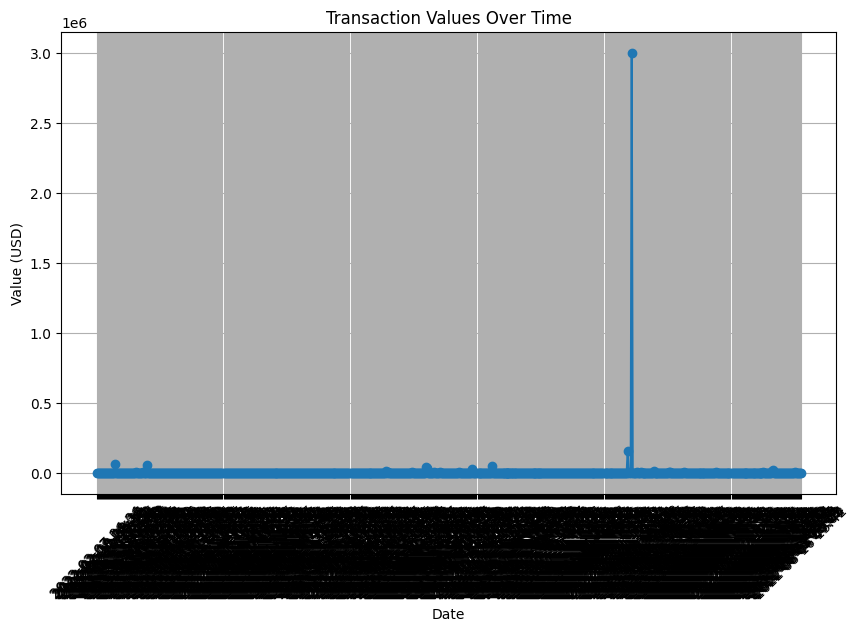

In [411]:
plt.figure(figsize=(10, 6))
plt.plot(withdrawals['date'], withdrawals['value_usd'], marker='o')
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.title('Transaction Values Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Some analysis on this data:

Users try to withdraw tokens but since the destination address does not have any funds to cover gas fees, there is no match on Ethereum.

This problem is not verified on the other end (ethereum -> moonbeam) because the transaction is always issued by the same address 0x776a9097e01de7e7aa2ddd92989f27c8b5c3ae68!!!

We need to get data on the addresses to which the withdrawals are being done. The main question is whether they had enough funds to cover transaction fees.

In [524]:
def create_df_with_ethereum_addresses_involved_in_unmatched_withdrawal(df):
    # Lets only store the date of tx and the destination address
    selected_columns_by_name = df[['date', 'value_usd']]

    selected_col2_by_index = df.iloc[:, 1].rename('timestamp')
    selected_col3_by_index = df.iloc[:, 2].rename('tx_hash')
    selected_col8_by_index = df.iloc[:, 7].rename('dst_address')

    dst_ethereum_addresses = pd.concat([selected_columns_by_name, selected_col2_by_index, selected_col3_by_index, selected_col8_by_index], axis=1)

    dst_ethereum_addresses['dst_address_balance_at_date'] = '0'
    dst_ethereum_addresses['dst_address_balance_today'] = '0'
    # Display the new DataFrame
    return dst_ethereum_addresses

In [525]:
dst_ethereum_addresses = create_df_with_ethereum_addresses_involved_in_unmatched_withdrawal(withdrawals)
print(len(dst_ethereum_addresses))
dst_ethereum_addresses.head()

729


,date,value_usd,timestamp,tx_hash,dst_address,dst_address_balance_at_date,dst_address_balance_today
0,2022-02-07 04:04,669.600355,1644206646,0x6dbcc55ed29940729b0863aa02d28c88256819125264...,0x2ecd872798b9850baf21796521b5a33c341f7f89,0,0
1,2022-02-07 16:36,0.999171,1644251778,0x7e14b9e195e88938f2b96ebb03138e5b2695a3719294...,0x039174bb81fa247fb9be25f1559c6612006a4779,0,0
2,2022-02-09 05:15,30.654699,1644383748,0x057d56e8a95658d54728aa09eb912e20ac67d194ce63...,0x02dde656d513034d4819285137a368f140d5deb5,0,0
3,2022-02-09 23:24,50.005127,1644449040,0x88a8414d11f2981a1ebff0859101687fe53d4b502f7d...,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,0,0
4,2022-02-10 18:46,0.618309,1644518772,0xe64ff1d7579293b07164efe2f40cc9127a23afae075d...,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,0,0


In [526]:
from dotenv import load_dotenv
import requests
import json
import os

load_dotenv()

def get_api_key():
    return os.getenv('ETHEREUM_API_KEY')

RPC_URL = f'https://svc.blockdaemon.com/ethereum/mainnet/native'  # Replace 'KEY' with your actual API key
REQ_HEADERS = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'X-API-Key': get_api_key()
}
REQ_DATA = {
    "id": 1,
    "jsonrpc": "2.0",
    "params": [],
    "method": "eth_getBalance"
}

blocks_df = pd.read_csv(f"../../data/{BRIDGE_NAME}/blocks/ethereum.csv")
blocks_df['timestamp'] = blocks_df['timestamp'].astype(int)

In [527]:
# We are going to retrieve the balance of each user on Ethereum, at the time the transaction on Moonbeam was issued, to see if the address had enough funds to cover for gas fees
# Therefore, we find the block number on Ethereum nearest to a certain timestamp and use the eth_getBalance RPC method
def find_closest_block(target_timestamp):
    blocks_df['time_diff'] = (blocks_df['timestamp'] - target_timestamp).abs()
    
    closest_index = blocks_df['time_diff'].idxmin()
    
    return blocks_df.loc[closest_index, 'block_number']

def fill_dst_ethereum_addresses_balances():
    length = len(dst_ethereum_addresses)

    for index, row in dst_ethereum_addresses.iterrows():
        dst_address = row['dst_address']
        block_number = find_closest_block(row['timestamp'])

        REQ_DATA['params'] = [dst_address, hex(block_number)]
        response = requests.post(RPC_URL, headers=REQ_HEADERS, data=json.dumps(REQ_DATA))

        REQ_DATA['params'] = [dst_address, hex(20190684)] # this is the last finalized block (ethereum) at the date of writing this script
        response2 = requests.post(RPC_URL, headers=REQ_HEADERS, data=json.dumps(REQ_DATA))

        if response.status_code == 200:
            balance = str(int(response.json()["result"], 16))
            balance2 = str(int(response2.json()["result"], 16))
            print(f"{index+1}/{length} Address {dst_address} had balance {balance} in block no {block_number}; current balance: {balance2}")
            dst_ethereum_addresses.at[index, 'balance_at_date'] = balance
            dst_ethereum_addresses.at[index, 'balance_today'] = balance2

        else:
            with open("./errors.txt", "a") as error_file:
                error_file.write(f"Transaction failed: {dst_address}\n")

In [528]:
fill_dst_ethereum_addresses_balances()

1/729 Address 0x2ecd872798b9850baf21796521b5a33c341f7f89 had balance 545792226092325 in block no 14156714; current balance: 545792226092325
2/729 Address 0x039174bb81fa247fb9be25f1559c6612006a4779 had balance 0 in block no 14160062; current balance: 60027270030000
3/729 Address 0x02dde656d513034d4819285137a368f140d5deb5 had balance 185842214586000 in block no 14169945; current balance: 121616584366770
4/729 Address 0xdfda0825ec6a7163c9ce15d576225c3f5f663795 had balance 11859173778791254 in block no 14174818; current balance: 726064277349000
5/729 Address 0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244 had balance 0 in block no 14180022; current balance: 12483677104869434
6/729 Address 0x0775ea2a88db33038c4069e41dda8d963b64c2a8 had balance 2558633532454694429 in block no 14183619; current balance: 52223603240628815
7/729 Address 0x0cacc94621ef3cc70bfb5f1279a62369a91b1d83 had balance 147918034080299322 in block no 14190519; current balance: 16763618044101584
8/729 Address 0xe68176a9d8a4323ea3

In [529]:
dst_ethereum_addresses.to_csv(f"./{BRIDGE_NAME}/data/dst_ethereum_addresses.csv", index=False)

In [52]:
dst_ethereum_addresses = pd.read_csv(f"./{BRIDGE_NAME}/data/dst_ethereum_addresses.csv")

# Create new dst_ethereum_addresses with aggregated data -- balance_at_date, balance_today with the count of each aggregated by 100 bins

dst_ethereum_addresses['balance_at_date'] = pd.to_numeric(dst_ethereum_addresses['balance_at_date'], errors='coerce')
dst_ethereum_addresses['balance_today'] = pd.to_numeric(dst_ethereum_addresses['balance_today'], errors='coerce')

dst_ethereum_addresses['balance_at_date_ether'] = dst_ethereum_addresses['balance_at_date'] / 10**18
dst_ethereum_addresses['balance_today_ether'] = dst_ethereum_addresses['balance_today'] / 10**18

add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match", len(dst_ethereum_addresses))
dst_ethereum_addresses.to_csv(f"./{BRIDGE_NAME}/data/dst_ethereum_addresses_with_ether.csv", index=False)

In [51]:
dst_ethereum_addresses

,date,value_usd,timestamp,tx_hash,dst_address,balance_at_date,balance_today,balance_at_date_ether,balance_today_ether,multiple_counts
0,2022-02-07 04:04,669.600355,1644206646,0x6dbcc55ed29940729b0863aa02d28c88256819125264...,0x2ecd872798b9850baf21796521b5a33c341f7f89,5.457922e+14,5.457922e+14,0.000546,0.000546,False
1,2022-02-07 16:36,0.999171,1644251778,0x7e14b9e195e88938f2b96ebb03138e5b2695a3719294...,0x039174bb81fa247fb9be25f1559c6612006a4779,0.000000e+00,6.002727e+13,0.000000,0.000060,False
2,2022-02-09 05:15,30.654699,1644383748,0x057d56e8a95658d54728aa09eb912e20ac67d194ce63...,0x02dde656d513034d4819285137a368f140d5deb5,1.858422e+14,1.216166e+14,0.000186,0.000122,False
3,2022-02-09 23:24,50.005127,1644449040,0x88a8414d11f2981a1ebff0859101687fe53d4b502f7d...,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,1.185917e+16,7.260643e+14,0.011859,0.000726,False
4,2022-02-10 18:46,0.618309,1644518772,0xe64ff1d7579293b07164efe2f40cc9127a23afae075d...,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,0.000000e+00,1.248368e+16,0.000000,0.012484,True
...,...,...,...,...,...,...,...,...,...,...
724,2022-08-03 19:41,4.614204,1659555702,0x7cedbe07930108eeb32ee02804033862ccd92fdc23ee...,0x081ca6de70660181a40e096fcecef2781cd7cb8e,2.510811e+16,2.459142e+16,0.025108,0.024591,False
725,2022-08-03 20:23,1000.036404,1659558228,0xb5005a22301c176767d34c10ac2c4fcce01015e02042...,0x5ff9e8c7f0be62f11d76c4f12692b7555552187b,7.849978e+14,1.354515e+15,0.000785,0.001355,False
726,2022-08-04 00:08,285.245682,1659571716,0x976fdf04e9bd4ffbaa0bf3ddead2a701aaecbc87e23d...,0x439511dd6fc762fe28bd015d68157ea462ceb88d,3.432093e+16,6.624934e+14,0.034321,0.000662,False
727,2022-08-04 07:44,10.000876,1659599058,0x2fe42dfe579fe56e09ccfd754df68b56d620412d3a3a...,0x37bd3c17b8830234a148c00bafcc3b6d38b965df,2.284094e+14,2.284094e+14,0.000228,0.000228,True


In [50]:
size = len(dst_ethereum_addresses[dst_ethereum_addresses['balance_at_date'] == 0])
print(f"Txs in which the destination had 0 balance on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_no_balance", size)

size2 = len(dst_ethereum_addresses[dst_ethereum_addresses['balance_at_date'].map(int) < 1100000000000000])
print(f"Txs in which the destination did not have funds to pay for tx fee on Ethereum: {size2}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_under_fee", size2)

Txs in which the destination had 0 balance on Ethereum: 121
Txs in which the destination did not have funds to pay for tx fee on Ethereum: 231


In [38]:
size = len(dst_ethereum_addresses[(dst_ethereum_addresses['balance_at_date'] == 0) & (dst_ethereum_addresses['balance_today'] == 0)])
print(f"Addresses that still today do not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_no_balance_and_under_fee", size)

Addresses that still today do not have funds on Ethereum: 72


In [39]:
value = dst_ethereum_addresses['value_usd'].sum()
print(f"Total Value Withdrawn in USD: ${value:.2f}")
print(f"Total Value Withdrawn in Million USD: ${value / 10**6:.2f}M")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_total_value", "{:,.2f}M".format(value / 10**6))

Total Value Withdrawn in USD: $3615285.36
Total Value Withdrawn in Million USD: $3.62M


In [40]:
sorted_dst_ethereum_addresses = dst_ethereum_addresses.sort_values('value_usd', ascending=False)

print("MAX:", max(dst_ethereum_addresses['value_usd']))
print("MIN:", min(dst_ethereum_addresses['value_usd']))
print("AVG:", sum(dst_ethereum_addresses['value_usd'])/len(dst_ethereum_addresses['value_usd']))
print("MEDIAN:", sorted_dst_ethereum_addresses['value_usd'].median())

sorted_dst_ethereum_addresses.head(10)

MAX: 3000846.8665931956
MIN: 2.995264216e-11
AVG: 4959.239180131261
MEDIAN: 8.191702355


,date,value_usd,timestamp,tx_hash,dst_address,balance_at_date,balance_today,balance_at_date_ether,balance_today_ether
549,2022-08-01 22:34,3.000847e+06,1659393270,0x417be5d4bb5027fb9b94f4ef98fb57bc4dd7b46852d6...,0x62a06db859bdaf7060ac8290b156234ce53fd6cb,2.501778e+17,9.501515e+13,0.250178,0.000095
545,2022-08-01 22:17,1.571899e+05,1659392262,0x5dd494f0c7e2efda5942bcd33255791a6429245271cf...,0x6accd26626c150a4b485e6c9c541b38fe0ab5915,2.514145e+18,5.916571e+17,2.514145,0.591657
18,2022-02-21 12:06,6.270581e+04,1645445208,0x3921d310b5938c104244cfe5298e1bb98f14451931d1...,0x1fe9fd1156688699f4ca017e72ee0d9873f9d758,2.668424e+20,5.155645e+16,266.842381,0.051556
50,2022-03-18 14:54,5.890200e+04,1647615240,0xb6e7d619aa139c0664103199a2c2177fbc65eaa8fe15...,0x0a776abbaae0e2161d0e131f57e605efbea4b99b,3.152199e+17,2.483767e+17,0.315220,0.248377
396,2022-07-27 05:38,4.549848e+04,1658900316,0x76130c4b890e3944ac8fe0ed18fe9d4f5a6856c91b22...,0xcbc21fbf92519f6d90c05a6fda1a7cb72fa6e02b,3.501507e+18,6.101418e+17,3.501507,0.610142
330,2022-06-12 14:16,4.004607e+04,1655043414,0x7d405819518249fd752894acce13c4b3302b5d2599e6...,0x3b11267dfc4b9ebe8427e8f557056b4b6ce98112,4.659972e+19,4.961553e+16,46.599725,0.049616
331,2022-06-13 09:13,3.078544e+04,1655111634,0x0108f129502e87edc7e8c4ec8a9c63cef499443a2bef...,0xdf5ce70cfe1addbc9fb26b5952d9d600dfe3f628,2.723637e+19,2.982899e+17,27.236370,0.298290
376,2022-07-18 12:46,2.999680e+04,1658148402,0x04dd0e10a0fc704a6c60fcb976d4dd2fbadd6709eb3c...,0xcee9c0d960b6c6c509cc3413172a4ff59bf21cd5,7.059776e+16,8.077229e+16,0.070598,0.080772
700,2022-08-02 19:25,1.785057e+04,1659468318,0xb843b6ec60e13cbd8b9c138a9a675c8ab34cd57ecedc...,0x0079dfb5d8262183367820d0ac36d00e4caed378,1.292698e+18,5.430904e+13,1.292698,0.000054
290,2022-05-19 00:50,1.363906e+04,1652921436,0x29a596dcff36fda9fe8ab88f63c4fa0b6a0e53203068...,0x05b72513b94a08e559e481b064ca27ff183564c6,2.748711e+18,5.422696e+15,2.748711,0.005423


So, there is one address (0x62a06Db859BDAf7060AC8290B156234Ce53FD6Cb) that, by itself, withdrew 3 Million USD but never withdrew those funds.

Actually, the address interacted 4 times with the bridge contract on Ethereum to deposit funds (100 USDC; 499 DAI; 1,000,000 USDC; 3,000,000 USDC). All these transactions are in our dataset as cross-chain transactions in CCTX_Deposit. However, they were never withdrawn. The address started 1 withdraw on the target chain that did not complete.

The rest of the transactions are kinda small in value. The median is 9 USD, which suggests there are a lot of different users that misuse the bridge and are not familiar with is internal functionality.

In [54]:
count_per_dst_address = dst_ethereum_addresses['dst_address'].value_counts()
multiple_counts = len(count_per_dst_address[count_per_dst_address > 1])
single_counts = len(count_per_dst_address[count_per_dst_address == 1])
print("Number of addresses that tried withdrawing exactly once:", single_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_single_tries", single_counts)
print("Number of addresses that tried withdrawing more than once:", multiple_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_multiple_tries", multiple_counts)

Number of addresses that tried withdrawing exactly once: 592
Number of addresses that tried withdrawing more than once: 58


In [56]:
# add a column to the df which says if they have multiple counts or not
dst_ethereum_addresses['multiple_counts'] = dst_ethereum_addresses['dst_address'].map(lambda address: count_per_dst_address[address] > 1)
# count number of unique addresses that have multiple counts
multiple_counts = len(dst_ethereum_addresses[dst_ethereum_addresses['multiple_counts']])
print(multiple_counts)

# print correlation between value_usd and multiple_counts
correlation = dst_ethereum_addresses['multiple_counts'].corr(dst_ethereum_addresses['value_usd'])
print("Correlation between multiple counts and value transferred:", correlation)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_correlation_USD_with_multiple_counts", "{:,.3f}".format(correlation))

137
Correlation between multiple counts and value transferred: -0.017443877397132684


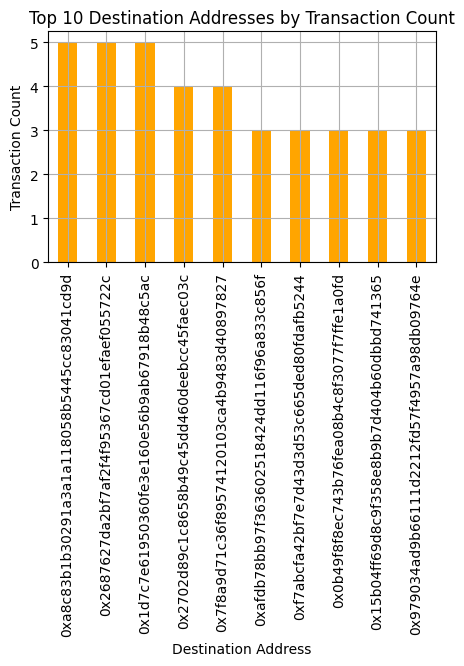

In [43]:
top_dst_addresses = sorted_dst_ethereum_addresses['dst_address'].value_counts().head(10)

# Bar plot
plt.figure(figsize=(5, 3))
top_dst_addresses.plot(kind='bar', color='orange')
plt.title('Top 10 Destination Addresses by Transaction Count')
plt.xlabel('Destination Address')
plt.ylabel('Transaction Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

There was one address that interacted with the bridge 5 times to withdraw funds but they were never withdrawn. These were made exactly at the time the bridge was hacked but not successful. Over the next hours, multiple transactions were issued to withdraw funds but none was successful because the contract on Ethereum was meanwhile paused.

This also shows the consequence of an attack, people wanting to withdraw funds from one blockchain to another to avoid using protocols.

In [44]:
before_attack_dst_ethereum_addresses = dst_ethereum_addresses[dst_ethereum_addresses['timestamp'] < 1659389551]
print(len(before_attack_dst_ethereum_addresses))
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before", len(before_attack_dst_ethereum_addresses))

size = len(before_attack_dst_ethereum_addresses[before_attack_dst_ethereum_addresses['balance_at_date'] == 0])
print(f"Addresses that did not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_no_balance", size)

size2 = len(before_attack_dst_ethereum_addresses[before_attack_dst_ethereum_addresses['balance_at_date'].map(int) < 1100000000000000])
print(f"Txs in which the destination did not have funds to pay for tx fee on Ethereum: {size2}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_under_fee", size2)

size = len(before_attack_dst_ethereum_addresses[(before_attack_dst_ethereum_addresses['balance_at_date'] == 0) & (before_attack_dst_ethereum_addresses['balance_today'] == 0)])
print(f"Addresses that still today do not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_no_balance_and_under_fee", size)

value = before_attack_dst_ethereum_addresses['value_usd'].sum()
print(f"Total Value not Withdrawn in USD: ${value:.2f}")
print(f"Total Value not Withdrawn in Thousands USD: ${value / 10**3:.2f}K")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_total_value", "{:,.2f}K".format(value / 10**3))

541
Addresses that did not have funds on Ethereum: 95
Txs in which the destination did not have funds to pay for tx fee on Ethereum: 185
Addresses that still today do not have funds on Ethereum: 55
Total Value not Withdrawn in USD: $343714.76
Total Value not Withdrawn in Thousands USD: $343.71K


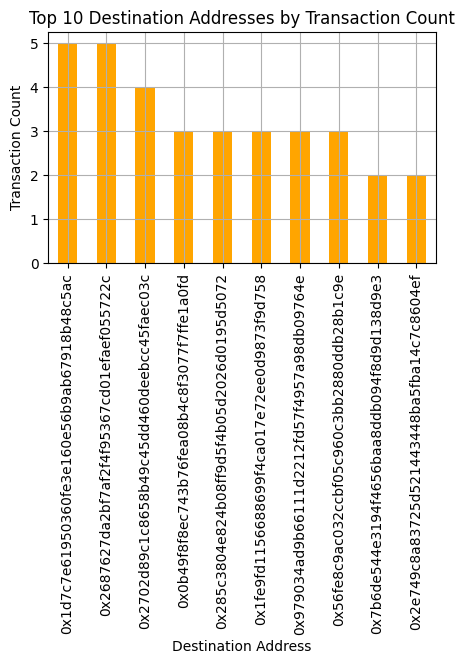

In [20]:
top_dst_addresses = before_attack_dst_ethereum_addresses['dst_address'].value_counts().head(10)

# Bar plot
plt.figure(figsize=(5, 3))
top_dst_addresses.plot(kind='bar', color='orange')
plt.title('Top 10 Destination Addresses by Transaction Count')
plt.xlabel('Destination Address')
plt.ylabel('Transaction Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [45]:
unique = len(before_attack_dst_ethereum_addresses['dst_address'].unique())
print(unique)

count_per_dst_address = before_attack_dst_ethereum_addresses['dst_address'].value_counts()
multiple_counts = len(count_per_dst_address[count_per_dst_address > 1])
single_counts = len(count_per_dst_address[count_per_dst_address == 1])
print("Number of addresses that tried withdrawing more than once:", multiple_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_single_tries", single_counts)

print("Number of addresses that tried withdrawing exactly once:", single_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_multiple_tries", multiple_counts)

494
Number of addresses that tried withdrawing more than once: 34
Number of addresses that tried withdrawing exactly once: 460


In [46]:
after_attack_dst_ethereum_addresses = dst_ethereum_addresses[dst_ethereum_addresses['timestamp'] >= 1659389551]
print(len(after_attack_dst_ethereum_addresses))
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after", len(after_attack_dst_ethereum_addresses))

size = len(after_attack_dst_ethereum_addresses[after_attack_dst_ethereum_addresses['balance_at_date'] == 0])
print(f"Addresses that did not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_no_balance", size)

size2 = len(after_attack_dst_ethereum_addresses[after_attack_dst_ethereum_addresses['balance_at_date'].map(int) < 1100000000000000])
print(f"Txs in which the destination did not have funds to pay for tx fee on Ethereum: {size2}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_under_fee", size2)

size = len(after_attack_dst_ethereum_addresses[(after_attack_dst_ethereum_addresses['balance_at_date'] == 0) & (after_attack_dst_ethereum_addresses['balance_today'] == 0)])
print(f"Addresses that still today do not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_no_balance_and_under_fee", size)

value = after_attack_dst_ethereum_addresses['value_usd'].sum()
print(f"Total Value not Withdrawn in USD: ${value:.2f}")
print(f"Total Value not Withdrawn in Million USD: ${value / 10**6:.2f}M")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_total_value", "{:,.2f}M".format(value / 10**6))

188
Addresses that did not have funds on Ethereum: 26
Txs in which the destination did not have funds to pay for tx fee on Ethereum: 46
Addresses that still today do not have funds on Ethereum: 17
Total Value not Withdrawn in USD: $3271570.60
Total Value not Withdrawn in Million USD: $3.27M


In [47]:
unique = len(after_attack_dst_ethereum_addresses['dst_address'].unique())
print(unique)

count_per_dst_address = after_attack_dst_ethereum_addresses['dst_address'].value_counts()
multiple_counts = len(count_per_dst_address[count_per_dst_address > 1])
single_counts = len(count_per_dst_address[count_per_dst_address == 1])
print("Number of addresses that tried withdrawing exactly once:", single_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_single_tries", single_counts)

print("Number of addresses that tried withdrawing more than once:", multiple_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_multiple_tries", multiple_counts)

159
Number of addresses that tried withdrawing exactly once: 136
Number of addresses that tried withdrawing more than once: 23


A provocative question... is a hack good or bad for bridges? They take users funds... If the hack is small enough it may compensate the value...

### Plot the difference between the withdrawal cross-chain transactions and the ones issued to the TC and not merged with any tx on the SC

This is a violation of a cross-chain rule, but not stealing funds from the bridge. Users are sending funds to the bridge and never withdrawing...

In [507]:
unmatched_cctxs_withdrawals = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_WithdrawalsWithoutMatch.csv", header=None, sep='\t')
unmatched_cctxs_withdrawals["value_usd"] = None

unmatched_cctxs_withdrawals["date"] = pd.to_datetime(unmatched_cctxs_withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in unmatched_cctxs_withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[8], day)
    unmatched_cctxs_withdrawals.at[index, "value_usd"] = tx_volume


matched_cctxs_withdrawals = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Withdrawal.csv", header=None, sep='\t')
matched_cctxs_withdrawals["value_usd"] = None

matched_cctxs_withdrawals["date"] = pd.to_datetime(matched_cctxs_withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in matched_cctxs_withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    matched_cctxs_withdrawals.at[index, "value_usd"] = tx_volume


# Convert the 'date' column to datetime
unmatched_cctxs_withdrawals['date'] = pd.to_datetime(unmatched_cctxs_withdrawals['date'])
unmatched_cctxs_withdrawals.set_index('date', inplace=True)

matched_cctxs_withdrawals['date'] = pd.to_datetime(matched_cctxs_withdrawals['date'])
matched_cctxs_withdrawals.set_index('date', inplace=True)

In [522]:
unmatched_cctxs_withdrawals_before_attack = unmatched_cctxs_withdrawals[unmatched_cctxs_withdrawals.index >= '2022-08-01']

print("Number of Txs After Attack: ", len(unmatched_cctxs_withdrawals_before_attack))
print("Total Value Withdrawn in USD: ${:.2f}".format(unmatched_cctxs_withdrawals_before_attack['value_usd'].sum()))

Number of Txs After Attack:  313
Total Value Withdrawn in USD: $24305024.03


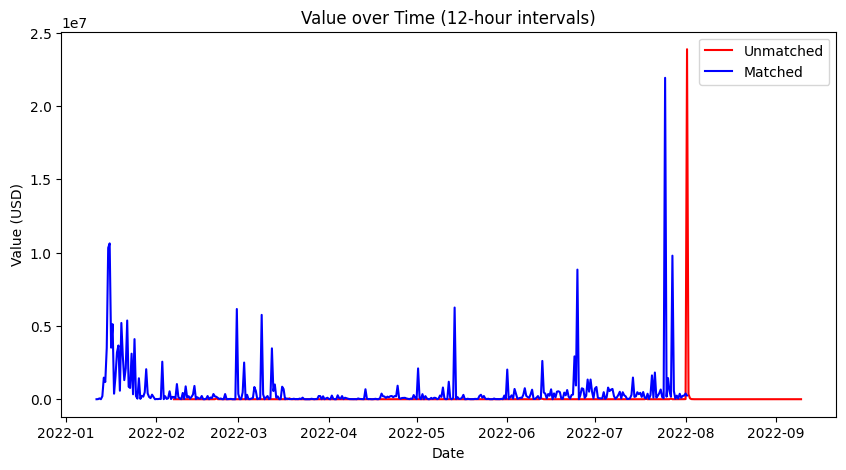

In [498]:
# Resample the data to 12-hour intervals and aggregate using the mean
unmatched_cctxs_withdrawals_resampled = unmatched_cctxs_withdrawals.resample('12h').sum()
matched_cctxs_withdrawals_resampled = matched_cctxs_withdrawals.resample('12h').sum()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(unmatched_cctxs_withdrawals_resampled.index, unmatched_cctxs_withdrawals_resampled["value_usd"], label='Unmatched', color='red')
plt.plot(matched_cctxs_withdrawals_resampled.index, matched_cctxs_withdrawals_resampled["value_usd"], label='Matched', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.title('Value over Time (12-hour intervals)')
plt.legend()


# Display the plot
plt.show()

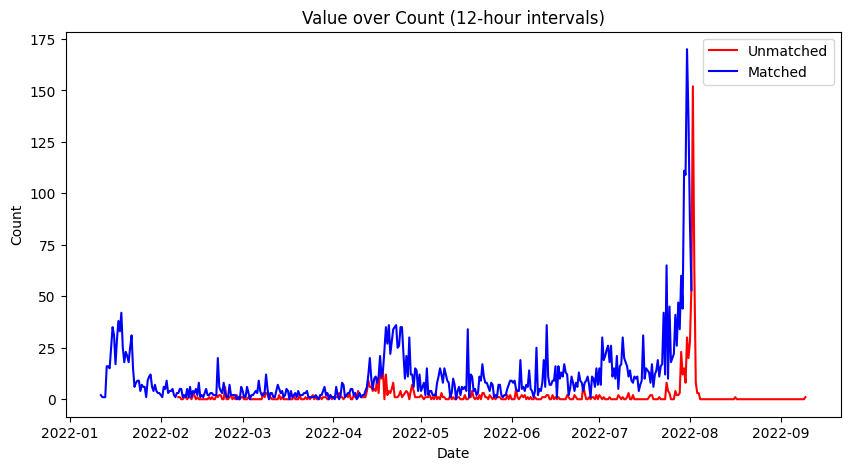

In [499]:
# Resample the data to 12-hour intervals and aggregate using the mean
unmatched_cctxs_withdrawals_resampled = unmatched_cctxs_withdrawals.resample('12h').count()
matched_cctxs_withdrawals_resampled = matched_cctxs_withdrawals.resample('12h').count()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(unmatched_cctxs_withdrawals_resampled.index, unmatched_cctxs_withdrawals_resampled["value_usd"], label='Unmatched', color='red')
plt.plot(matched_cctxs_withdrawals_resampled.index, matched_cctxs_withdrawals_resampled["value_usd"], label='Matched', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Value over Count (12-hour intervals)')
plt.legend()


# Display the plot
plt.show()

In [517]:
unmatched_cctxs_withdrawals.rename(columns={0: 'origin_chain_id', 1: 'origin_timestamp', 2: 'origin_transaction_hash', 3: 'withdrawal_id', 4: 'origin_token', 5: 'dst_token', 6: 'sender', 7: 'beneficiary', 8: 'amount'}, inplace=True)
matched_cctxs_withdrawals.rename(columns={0: 'origin_chain_id', 1: 'origin_timestamp', 2: 'origin_transaction_hash', 3: 'dst_chain_id', 4: 'dst_timestamp', 5: 'dst_transaction_hash', 6: 'withdrawal_id', 7: 'origin_token', 8: 'dst_token', 9: 'sender', 10: 'beneficiary', 11: 'amount'}, inplace=True)

unmatched_cctxs_withdrawals['matched'] = False
matched_cctxs_withdrawals['matched'] = True

all_columns = set(matched_cctxs_withdrawals.columns).union(set(unmatched_cctxs_withdrawals.columns))

for col in all_columns:
    if col not in unmatched_cctxs_withdrawals.columns:
        unmatched_cctxs_withdrawals[col] = None

# Reorder columns to match the order of matched_cctxs_withdrawals
new_unmatched_cctxs_withdrawals = unmatched_cctxs_withdrawals[matched_cctxs_withdrawals.columns]

# Append rows from unmatched_cctxs_withdrawals to matched_cctxs_withdrawals
merged = pd.concat([matched_cctxs_withdrawals, new_unmatched_cctxs_withdrawals], ignore_index=False)

merged.to_csv(f"./{BRIDGE_NAME}/data/matched_and_unmatched_tc_withdrawals.csv")

## Token Withdrawals in S

In [321]:
# Calculate USD value for each transaction

cctxs = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/SC_ValidERC20TokenWithdrawal.csv", header=None, sep='\t')
cctxs["value_usd"] = None

cctxs["date"] = pd.to_datetime(cctxs.iloc[:, 0], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in cctxs.iterrows():
    day = datetime.fromtimestamp(row.loc[0]).strftime('%Y-%m-%d')
    try:
        dst_token = MAP_SRC_DST_TOKENS[row.loc[4]]
        tx_volume = calculateTxValueInUSD(MAP_SRC_DST_TOKENS[row.loc[4]], row.loc[6], day)
    except Exception as e:
        tx_volume = np.nan
    
    cctxs.at[index, "value_usd"] = tx_volume

cctxs['date'] = pd.to_datetime(cctxs['date'])
cctxs.set_index('date', inplace=True)

print(len(cctxs))
cctxs.head()

4869


,0,1,2,3,4,5,6,value_usd
date,,,,,,,,
2022-01-11 13:27:00,1641907661,0x64a8fd7047329f95631abdfcfbf224ad78e8e5d8fb61...,1,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,0xba8d75baccc4d5c4bd814fde69267213052ea663,6648936,1000000000000000000,8.971502
2022-01-12 10:06:00,1641982002,0x60e20861d22a6931d9731e0c00dcd6984857140c86cf...,3,0x26bc3110960b1888c4bd043dbd16a6c7336ab488,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,6648936,1915131000000000000,6232.679048
2022-01-12 23:19:00,1642029545,0x73bae115015885371b295daad8225493571b6963f550...,4,0xa98c5eaffd2e339f2c67a922b39008938044baaa,0x6b175474e89094c44da98b954eedeac495271d0f,6648936,54815000000000000000000,54756.474353
2022-01-13 15:05:00,1642086325,0xbe2a5c91c7ae75ea52543e3aceb2a8cc662bc0c6173a...,8,0x09f258f399c421afff697ff75caca4ba3c73f02b,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,6648936,1699000000000000000,5618.710559
2022-01-13 15:09:00,1642086569,0x46c559ec63879c00c6b4b36863d71e08496ceec241fe...,7,0xf08961d8863c0535253061bcb7ec10034adacd60,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,6648936,1699900000000000000,5621.686921


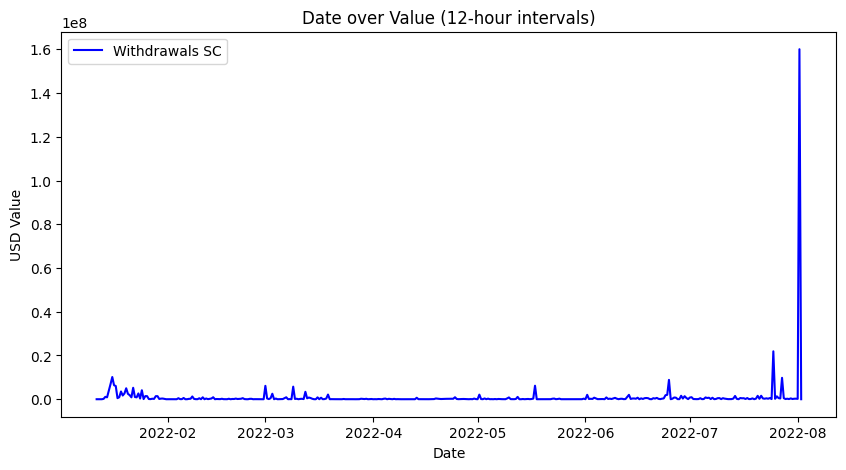

In [ ]:
# Resample the data to 12-hour intervals and aggregate using the mean
withdrawals = cctxs.resample('12h').sum()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(withdrawals.index, withdrawals["value_usd"], label='Withdrawals SC', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('USD Value')
plt.title('Date over Value (12-hour intervals)')
plt.legend()


# Display the plot
plt.show()

In [11]:
# Calculate USD value for each transaction

cctxs = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/SC_WithdrawalsWithoutMatch.csv", header=None, sep='\t')
cctxs["value_usd"] = None

cctxs["date"] = pd.to_datetime(cctxs.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in cctxs.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    try:
        dst_token = MAP_SRC_DST_TOKENS[row.loc[4]]
        tx_volume = calculateTxValueInUSD(MAP_SRC_DST_TOKENS[row.loc[4]], row.loc[6], day)
    except Exception as e:
        tx_volume = np.nan
    
    cctxs.at[index, "value_usd"] = tx_volume

print(len(cctxs))
cctxs.head()

387


,0,1,2,3,4,5,6,value_usd,date
0,6648936,1642623577,0xf3873df366084bb0b8ccbaed1af24120746fffa788d6...,312,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x3030303030303030303030303030353866423433,1000000,1.000412,2022-01-19 20:19
1,6648936,1647647738,0x1c6a6264c51dea4b4cc0f081a3663f702dd12d2cacdb...,310,0x853d955acef822db058eb8505911ed77f175b99e,0x3030303030303030303030303030353866423433,1000000000000000000,0.997608,2022-03-18 23:55
2,6648936,1647647779,0x6e1b23f2449ee1dd8f775b9aa25f5505406e999bbb10...,311,0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0,0x3030303030303030303030303030353866423433,1000000000000000000,17.722433,2022-03-18 23:56
3,6648936,1651338728,0xf5e8af728a7127c896e3f06faa56344f1aa6110844e5...,1992,0x93581991f68dbae1ea105233b67f7fa0d6bdee7b,0x4180e90db112047e588b1037db8ed8235c9e1382,200000000000000000000,NaN,2022-04-30 17:12
4,6648936,1651513302,0x6a98904dd1202138082c4d096d95f6d4cd593520a75e...,2032,0xbf49f2231ed4bb2c907f18a7ba5da234be1fc520,0xdf8b9d67bca5392bda67cc9a1f79f99f1b858a1f,1111111111,NaN,2022-05-02 17:41


In [13]:
# filter based on column 1 > 1659389520
cctxs = cctxs[cctxs[1] > 1659389520]
print(len(cctxs))
cctxs.head()

382


,0,1,2,3,4,5,6,value_usd,date
5,6648936,1659389551,0x61497a1a8a8659a06358e130ea590e1eed8956edbd99...,5078,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xf57113d8f6ff35747737f026fe0b37d4d7f42777,10000000000,2297085.882,2022-08-01 21:32
6,6648936,1659389551,0xa5fe9d044e4f3e5aa5bc4c0709333cd2190cba0f4e7f...,5078,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xa8c83b1b30291a3a1a118058b5445cc83041cd9d,10000000000,2297085.882,2022-08-01 21:32
7,6648936,1659389551,0xb1fe26cc8892f58eb468f5208baaf38bac422b5752cc...,5078,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xb5c55f76f90cc528b2609109ca14d8d84593590e,10000000000,2297085.882,2022-08-01 21:32
8,6648936,1659389551,0x40163166dfeaab8ee80e7b0acc62768cef84b7047b42...,5078,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x000000000000660def84e69995117c0176ba446e,10000000000,2297085.882,2022-08-01 21:32
9,6648936,1659389563,0x3f9083e432932d83e5b4560203b5a24395bcb24ae3ea...,5078,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xd1a7feb0317bbe40ac2334c29579424942ad8f17,10000000000,2297085.882,2022-08-01 21:32


In [14]:
cctxs.fillna(0)
total_value = cctxs["value_usd"].sum()
total_addresses = cctxs.iloc[:,5].unique()
print("TOTAL UNIQUE ADDRESSES IDENTIFIED: " + str(len(total_addresses)))
print("TOTAL VALUE (USD): " + str(total_value))
print("TOTAL VALUE (MILLION USD): " + str(total_value / 10**6))

TOTAL UNIQUE ADDRESSES IDENTIFIED: 279
TOTAL VALUE (USD): 159577598.45990306
TOTAL VALUE (MILLION USD): 159.57759845990307


/var/folders/bb/lz0b6jv55n96zj41zzsd4pc80000gn/T/ipykernel_38900/4214297528.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cctxs.fillna(0)


In [15]:
cctxs.rename(columns={0: 'dst_chain_id', 1: 'dst_timestamp', 2: 'dst_transaction_hash', 3: 'withdrawal_id', 4: 'dst_token', 5: 'beneficiary', 6: 'amount'}, inplace=True)
cctxs.to_csv(f"./{BRIDGE_NAME}/data/attacks.csv", index=False)

### Compare our dataset with existing one from Peckshield
The dataset from Peckshield aggregates the funds per EOA. Our dataset aggregates per contract, be it EOA or Contract Address. What happens multiple times is that one EOA deploys multiple contracts on the same transaction (or multiple) and then the funds are scattered among them. We will rely on transaction.facts (which contains to=null whenever there is a contract being deployed) and we will merge the data with this our dataset. Once we have a dataset with all EOAs and tokens stolen, we can compare the datasets.

In [18]:
# for each transaction (col 3) in df "cctxs", we will get the line corresponding to that tx in "transaction.facts"csv file (col 3).
# We will check col6. If col6 (to) is equal to None, then we extract the sender (col5) and store in the dataset the new column from cctxs 
# where col6 is replaced by this value

transaction_facts = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/transaction.facts', header=None, sep='\t')

# Set column names for clarity
transaction_facts.columns = ['col1', 'col2', 'tx_hash', 'col4', 'from', 'to', 'col7', 'col8', 'col9']

new_cctxs = cctxs.copy(deep=True)
new_cctxs.insert(6, 'corresponding_eoa', None)

for idx, row in cctxs.iterrows():
    tx_hash = row['dst_transaction_hash']

    corresponding_tx = transaction_facts[transaction_facts['tx_hash'] == tx_hash]

    from_value = corresponding_tx.iloc[0]['from']
    new_cctxs.at[idx, 'corresponding_eoa'] = from_value

# Display the new DataFrame
new_cctxs.head()

# Save the new DataFrame to a CSV file if needed
new_cctxs.to_csv(f'./{BRIDGE_NAME}/modified_attacks.csv', index=False)

print("total unique EOAs:", len(new_cctxs["corresponding_eoa"].unique()))

total unique EOAs: 45


In [19]:
def load_and_compare_df_cols(col_1, col_2):
    # Get the difference between the "hashes" columns
    hashes1 = set(col_1)
    hashes2 = set(col_2)
    
    # Find elements in df1 that are not in df2
    diff1_to_2 = hashes1 - hashes2

    # Find elements in df2 that are not in df1
    diff2_to_1 = hashes2 - hashes1
    
    return diff1_to_2, diff2_to_1

In [20]:
peckshield_addresses = pd.read_csv(f"./{BRIDGE_NAME}/data/all_addresses_peckshield.csv")

peckshield_misses, our_df_misses = load_and_compare_df_cols(new_cctxs["corresponding_eoa"], peckshield_addresses["address"])

print(f'Addresses highlighted by our data but not by Peckshield:')
print(len(peckshield_misses))
print(peckshield_misses)

print(f'Addresses highlighted by Peckshield not in our data:')
print(len(our_df_misses))
print(our_df_misses)

Addresses highlighted by our data but not by Peckshield:
9
{'0x9bdeb450375770cfbd5c86c740d3bdb8fc980e5f', '0x4081c2e9338aab51480acbb34f6664e32509b9f7', '0x1a54220656fa426a20331141324260398a549314', '0x58d16473f5cfbd3970e624e9aeab5528af2d9a40', '0x93bcf26c4dd1ad618251567f23568e1b836ff013', '0x4f2094a42e60d736868a7d4de868b8342fff06c6', '0x2d3a838701c301b3c402c91b3b3f852b7adc0418', '0x217e76555a1f1a3f591e8d12668d42c5394e441e', '0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f'}
Addresses highlighted by Peckshield not in our data:
5
{'0x00000cc0a3d2430b13894624bcdee0b2bb3628e1', '0x35679e61e5946f711ca1288255b1f32376c416d7', '0xd45ece50811082f6185a73b6a1d7c6eef0e75e0f', '0xbf2d5d8ebf05947245b3d7f38b2776a6a49710dd', '0x11b3544828b358cd528e72a9f7ffb7212fc3fb85'}


In [39]:
# we then check the alternative_chains.facts and search for these addresses
txs_to_alternative_chains = pd.read_csv(f"../datalog/{BRIDGE_NAME}/facts/alternative_chains.facts", header=None, sep="\t")

from_addresses = set(txs_to_alternative_chains.iloc[:,3])
count = 0

for address in our_df_misses:
    if address not in from_addresses:
        print("Missing Address")
    else:
        count += 1

print("Addresses highlighted out of scope in our analysis:", count)

Addresses highlighted out of scope in our analysis: 5


ALL ADDRESSES FOUND IN PECKSHIELD'S DATASET BETWEEN MOONBEAM AND ETHEREUM ARE IN OURS!

In [41]:
# print number of unique withdrawal_ids
unique_withdrawal_ids = len(new_cctxs["withdrawal_id"].unique())
print("Number of unique withdrawal_ids:", unique_withdrawal_ids)
# print number of non-unqiue withdrawal_ids
non_unique_withdrawal_ids = len(new_cctxs) - unique_withdrawal_ids
print("Number of non-unique withdrawal_ids:", non_unique_withdrawal_ids)

Number of unique withdrawal_ids: 14
Number of non-unique withdrawal_ids: 368


### Compare our dataset with existing one from nomad-xyz (https://github.com/nomad-xyz/hack-data.git)

In [9]:
with open(f"./{BRIDGE_NAME}/data/nomad_xyz.json", "r") as read_file:
    nomad_xyz_data = json.load(read_file)

# filter objects based on "homeDomain" that must match "moonbeam"
moonbeam_data = [obj for obj in nomad_xyz_data if obj['homeDomain'] == "moonbeam"]
print("Total transactions identified by Nomad-XYZ:", len(moonbeam_data))

Total transactions identified by Nomad-XYZ: 246


In [17]:
import pandas as pd

transaction_facts = pd.read_csv(f'./{BRIDGE_NAME}/modified_attacks.csv')
dst_transaction_hash_column = transaction_facts['dst_transaction_hash']

transaction_hashes = [tx['transactionHash'] for tx in moonbeam_data]

diff = set(dst_transaction_hash_column) - set(transaction_hashes)
print(len(dst_transaction_hash_column))
print(len(transaction_hashes))
print(len(diff))
print(diff)

382
246
136
{'0x04318f01698bd6875a0b1707b2109d3f414e007c3535562bc90bcce79c6fa63e', '0x40240be1bf54ae0145249b7c590569f0d1ec18a557060529ab7e358dbad03dd1', '0xa304a513cc1b62da3d0237b90078f3f9f9e20fac38718e1c04dd2e589bef51bd', '0x18bf5df035360b754296f36528b24f8873c8a2155c84eb5bd0cc6cd3acee5512', '0xc2af8ac586489d4c555a273d965aa233ee03dcce31e1028b067497a753f33903', '0x1eaf063edb953ecc76eb318806efe71e8e52090f296a669a01162803f3ee10ac', '0xb1d7a67de918761cdbe821b9ce2c887bea45da26841f8af851952c61e4680c60', '0xda0e1943f7e7dce705fa53c4852dcaafae19cfded6cbd7cc6f6b7e6301a4f1b2', '0x755d937557e026f2dd348495ee94f8b0a324f8d7a67981b6b6374c4716e5be71', '0x2d304c112e1ef9dc709cafc7948904282cbbb35348425bfc31a122d9caf90fc3', '0x4cc07aa123626e806531060660c607bc3656b6c8a597fb9a5d83d0aff8f21e54', '0x61497a1a8a8659a06358e130ea590e1eed8956edbd99dbb2048cfb46850a8f17', '0x7a8048ad1ccb72ac9af26e952680b0cb8ad7c5fd830151535a0f9a01920681eb', '0xdfd0a844e6eee910bb108a6ba42403596605667c72146065b2bba6292cae1081', '0xdc5a

# Analysis on the data of the selected interval + additional data retrieved on Ethereum

In [19]:
cctxs = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_WithdrawalsMatchWithAdditionalData.csv", header=None, sep='\t')
cctxs["value_usd"] = None

for index, row in cctxs.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    cctxs.at[index, "value_usd"] = tx_volume

print(len(cctxs))
cctxs

99


,0,1,2,3,4,5,6,7,8,9,10,11,value_usd
0,1650811245,1658652534,0x66619fe90a04633cbdf1ddfc2dff595d097cac80f0fc...,6648936,1673117075,0x03f98ece290918b219334676987b283709298471250d...,3842,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc271e8e809505b9e46c7e60e8ed56a9b9814a796,0xc271e8e809505b9e46c7e60e8ed56a9b9814a796,100000000000000000,144.720699
1,1650811245,1659182436,0x04a446b6cd387efd495813ab4c6c291efc990d99884e...,6648936,1672601759,0xe8e46f506d2f24fef772b1e64b43e717a57c997c1459...,4416,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa223c7692d7a80c98a94ce0f2ac19dfeb8fd47ca,0xa223c7692d7a80c98a94ce0f2ac19dfeb8fd47ca,110000000000000000,185.315094
2,1650811245,1659261924,0x42f1b21e8e2d18f9e15ea0592e8aa06d9a8871371a4b...,6648936,1672285247,0x6a70ee30d39bce41bec1a0bbea7cbbc9cd467e8bc35c...,4689,0x8e70cd5b4ff3f62659049e74b6649c6603a0e594,0xdac17f958d2ee523a2206206994597c13d831ec7,0xc239876bdf21a9746b2da99622e323c53dd24740,0xc239876bdf21a9746b2da99622e323c53dd24740,650000000,650.132359
3,1650811245,1659261996,0x34e9440d67c6877699cbcd6dbd85e1e8d473f7d57ffb...,6648936,1672285775,0x4287d44d327d87456dde4b239670d4bd2bcecf98a967...,4690,0x8e70cd5b4ff3f62659049e74b6649c6603a0e594,0xdac17f958d2ee523a2206206994597c13d831ec7,0x201b856fe2d5539cbd325cd2c491ca75e4dfa2e7,0x201b856fe2d5539cbd325cd2c491ca75e4dfa2e7,457000000,457.093059
4,1650811245,1659262104,0xf48f6dd7577de452e9803b50292ffe07b2ca476ede30...,6648936,1672295867,0x4445e51270d99cf57510ae8a483e9be94d89ed827e7c...,4691,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x07ac816d88643a7140cba1624980a0c5e12e7a18,0x07ac816d88643a7140cba1624980a0c5e12e7a18,378000000,377.938526
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1650811245,1659471192,0x316959257904ef675dd9eedfd06f94c2df2bfca2e672...,6648936,1671805175,0x0cbc02f7ebef6ecb4038db2db652095a4624d67c5ad2...,5308,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x4deec6b68b3090fc7a7e7a494fc8fa65080c75e8,0x4deec6b68b3090fc7a7e7a494fc8fa65080c75e8,50000000000000000,80.881682
95,1650811245,1659484788,0x3e6cb18b3eb958e5f01d2154c8b1a5d6a1d8eb134329...,6648936,1671577751,0x567017bc96d6f804530b0ff28e689988bf0f21e87162...,5323,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x5f45b03ecff80eb6b4d5829661fd49a241f06a33,0x5f45b03ecff80eb6b4d5829661fd49a241f06a33,503214148,503.232467
96,1650811245,1659489240,0xdb3c25791d3d75053cc036c9fe9ea8410dba33add1c3...,6648936,1715057399,0x5b03906083c10a01a8271bde34d44f0eebdb977ccf7c...,5324,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x62c0c8a0456a977aa007326bb9d8cc1e9d3cc082,0x62c0c8a0456a977aa007326bb9d8cc1e9d3cc082,100000000,100.00364
97,1650811245,1659581208,0xc187339d83d31557cce0fea2f7cf345608388c840c96...,6648936,1676599607,0x8e9656371a20ee4d17393afdda86f0edada4c60d8f75...,5336,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xafea69a7f761be7b359b0f5daed8afff8ebca4fe,0xafea69a7f761be7b359b0f5daed8afff8ebca4fe,391631124,391.665417


In [24]:
add_data_erc = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_ValidERC20TokenWithdrawal.csv", header=None, sep='\t')
add_txs_erc = add_data_erc[1].to_list()

add_data_native = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_ValidNativeTokenWithdrawal.csv", header=None, sep='\t')
add_txs_native = add_data_native[1].to_list()

withdrawals_native_tc_matched_by_additional_data = cctxs[cctxs[2].isin(add_txs_erc)]
print("Events matched in additional data for ERC20s Trasfers:", len(withdrawals_native_tc_matched_by_additional_data))

withdrawals_native_tc_matched_by_additional_data = cctxs[cctxs[2].isin(add_txs_native)]
print("Events matched in additional data for Native Trasfers:", len(withdrawals_native_tc_matched_by_additional_data))

Events matched in additional data for ERC20s Trasfers: 98
Events matched in additional data for Native Trasfers: 1


In [539]:
addTransactionTimeDifferencesToDataframe(cctxs, 1).head()

NUMBER OF DATAPOINTS: 99
MAX CCTX LATENCY: 55568159
MIN CCTX LATENCY: 9388757
AVG CCTX LATENCY: 16329236.757575758
AVG CCTX LATENCY (MINS): 272153.94595959596
AVG CCTX LATENCY (HOURS): 4535.8990993266
AVG CCTX LATENCY (DAYS): 188.99579580527498
Standard Deviation of CCTX Latency: 8468650.574826464


,0,1,2,3,4,5,6,7,8,9,10,11,value_usd,time_difference,day_rounded,datetime_group
0,1650811245,1658652534,0x66619fe90a04633cbdf1ddfc2dff595d097cac80f0fc...,6648936,1673117075,0x03f98ece290918b219334676987b283709298471250d...,3842,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc271e8e809505b9e46c7e60e8ed56a9b9814a796,0xc271e8e809505b9e46c7e60e8ed56a9b9814a796,100000000000000000,144.720699,14464541,24,2022-07-24 00:00
1,1650811245,1659182436,0x04a446b6cd387efd495813ab4c6c291efc990d99884e...,6648936,1672601759,0xe8e46f506d2f24fef772b1e64b43e717a57c997c1459...,4416,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa223c7692d7a80c98a94ce0f2ac19dfeb8fd47ca,0xa223c7692d7a80c98a94ce0f2ac19dfeb8fd47ca,110000000000000000,185.315094,13419323,30,2022-07-30 00:00
2,1650811245,1659261924,0x42f1b21e8e2d18f9e15ea0592e8aa06d9a8871371a4b...,6648936,1672285247,0x6a70ee30d39bce41bec1a0bbea7cbbc9cd467e8bc35c...,4689,0x8e70cd5b4ff3f62659049e74b6649c6603a0e594,0xdac17f958d2ee523a2206206994597c13d831ec7,0xc239876bdf21a9746b2da99622e323c53dd24740,0xc239876bdf21a9746b2da99622e323c53dd24740,650000000,650.132359,13023323,31,2022-07-31 00:00
3,1650811245,1659261996,0x34e9440d67c6877699cbcd6dbd85e1e8d473f7d57ffb...,6648936,1672285775,0x4287d44d327d87456dde4b239670d4bd2bcecf98a967...,4690,0x8e70cd5b4ff3f62659049e74b6649c6603a0e594,0xdac17f958d2ee523a2206206994597c13d831ec7,0x201b856fe2d5539cbd325cd2c491ca75e4dfa2e7,0x201b856fe2d5539cbd325cd2c491ca75e4dfa2e7,457000000,457.093059,13023779,31,2022-07-31 00:00
4,1650811245,1659262104,0xf48f6dd7577de452e9803b50292ffe07b2ca476ede30...,6648936,1672295867,0x4445e51270d99cf57510ae8a483e9be94d89ed827e7c...,4691,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x07ac816d88643a7140cba1624980a0c5e12e7a18,0x07ac816d88643a7140cba1624980a0c5e12e7a18,378000000,377.938526,13033763,31,2022-07-31 00:00


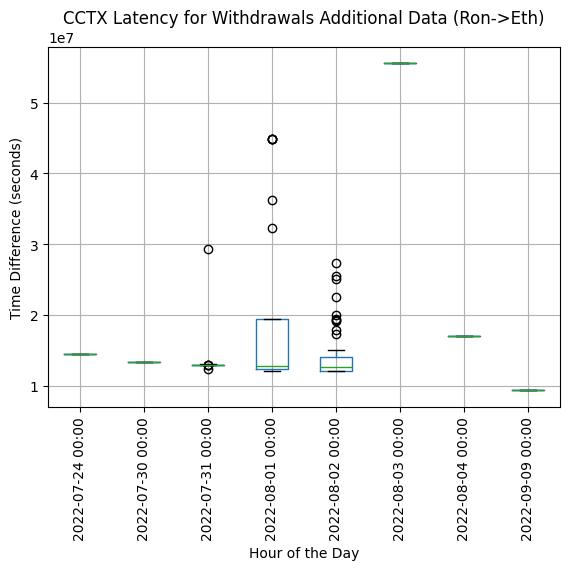

In [540]:
plotTimeDifferencesBoxplot(cctxs, False, "CCTX Latency for Withdrawals Additional Data (Ron->Eth)")

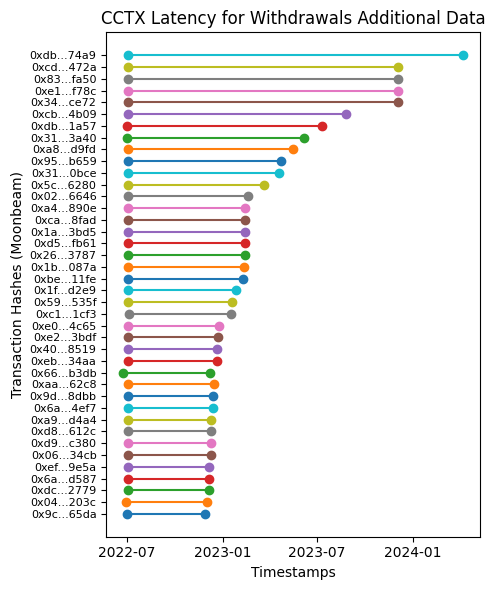

In [560]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the CSV has columns: 'address', 'timestamp1', 'timestamp2'
# Convert timestamps to datetime if they are not already
cctxs['timestamp1'] = pd.to_datetime(cctxs.iloc[:,1], unit='s')
cctxs['timestamp2'] = pd.to_datetime(cctxs.iloc[:,4], unit='s')
cctxs.rename(columns={cctxs.columns[2]: 'tx_hash'}, inplace=True)

def shorten_tx_hash(tx_hash, length=4):
    return f"{tx_hash[:length]}...{tx_hash[-length:]}"

cctxs['short_hashes'] = [shorten_tx_hash(tx_hash) for tx_hash in cctxs['tx_hash']]

cctxs = cctxs.sort_values(by='time_difference')

df = cctxs[['short_hashes', 'timestamp1', 'timestamp2', 'time_difference']].tail(40)

# Create the plot
plt.figure(figsize=(5, 6))

# Plot each pair of timestamps for each address
for _, row in df.iterrows():
    plt.plot([row['timestamp1'], row['timestamp2']], [row['short_hashes'], row['short_hashes']], marker='o')

min_date = df['timestamp1'].min()
max_date = df[['timestamp1', 'timestamp2']].max().max()

# Create date range with 2-week intervals
date_range = pd.date_range(start=min_date, end=max_date, freq='6ME')

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Transaction Hashes (Moonbeam)')
plt.title('CCTX Latency for Withdrawals Additional Data')

plt.xticks(ticks=date_range, labels=[date.strftime('%Y-%m') for date in date_range], rotation=0)
plt.yticks(ticks=df['short_hashes'], fontsize=8)
# Show plot
plt.tight_layout()

plt.show()

In [555]:
# calculate count per year
cctxs['year'] = cctxs['timestamp2'].dt.year

# Group by year and count the number of transactions
count_per_year = cctxs.groupby('year').size()
count_per_year

year
2022    60
2023    34
2024     5
dtype: int64

The one from the top is verified here (a withdrawal with id `5324`):
https://moonscan.io/tx/0xdb3c25791d3d75053cc036c9fe9ea8410dba33add1c393fec8727444212974a9#eventlog
https://etherscan.io/tx/0x5b03906083c10a01a8271bde34d44f0eebdb977ccf7c408c2aace0cac07c8481#eventlog

## Local Blockchain Evaluation

In [15]:
sc_deposit_facts = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/sc_deposit.facts', header=None, sep='\t')
sc_deposit_facts_tx_hashes = sc_deposit_facts[0]

alternative_chains = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/alternative_chains.facts', header=None, sep='\t')
alternative_chains_tx_hashes = alternative_chains[1].to_list()

sc_deposit_facts_included = sc_deposit_facts[~sc_deposit_facts[0].isin(alternative_chains_tx_hashes)]
print("Total ERC20 Transfers not for/from alternative chains in SC:", len(sc_deposit_facts_included))

valid_native_deposits = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SC_ValidNativeTokenDeposit.csv', header=None, sep='\t')
valid_native_deposits_tx_hashes = valid_native_deposits[1]
print("Total SC Deposit Events:", len(valid_native_deposits_tx_hashes))
add_metrics_to_latex_file(BRIDGE_NAME, "SC_Deposit_Facts", len(valid_native_deposits_tx_hashes))

Total ERC20 Transfers not for/from alternative chains in SC: 7187
Total SC Deposit Events: 7187


In [16]:
singe_token_deposits = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SingleTokenDeposits.csv', header=None, sep='\t')
singe_token_deposits["value_usd"] = None

alternative_chains = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/alternative_chains.facts', header=None, sep='\t')
alternative_chains_tx_hashes = alternative_chains[1].to_list()

singe_token_deposits_included = singe_token_deposits[~singe_token_deposits[2].isin(alternative_chains_tx_hashes)]
print("Total ERC20 Transfers not for/from alternative chains in SC:", len(singe_token_deposits_included))

singe_token_deposits_included["date"] = pd.to_datetime(singe_token_deposits_included.iloc[:, 0], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in singe_token_deposits_included.iterrows():
    day = datetime.fromtimestamp(row.loc[0]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[5], day)
    singe_token_deposits_included.at[index, "value_usd"] = tx_volume

print(len(singe_token_deposits_included))
singe_token_deposits_included.head()
add_metrics_to_latex_file(BRIDGE_NAME, "Deposits_Left_S_Facts", len(singe_token_deposits_included))


Total ERC20 Transfers not for/from alternative chains in SC: 39
39


In [17]:
print(f"Total Value Sent to the Bridge in USD: ${singe_token_deposits_included['value_usd'].sum():.2f}")
print(f"Total Value Sent to the Bridge in Thousands USD: ${singe_token_deposits_included['value_usd'].sum() / 10**3:.2f}K")

sorted_singe_token_deposits = singe_token_deposits_included.sort_values('value_usd', ascending=False)
# populate nan
sorted_singe_token_deposits.fillna(0, inplace=True)
sorted_singe_token_deposits.head(5)

Total Value Sent to the Bridge in USD: $93856.51
Total Value Sent to the Bridge in Thousands USD: $93.86K


/var/folders/bb/lz0b6jv55n96zj41zzsd4pc80000gn/T/ipykernel_68128/2357585395.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sorted_singe_token_deposits.fillna(0, inplace=True)


,0,1,2,3,4,5,value_usd,date
30,1659465207,6648936,0x4c3ad246adbf6f3891669d02744e7772540ec39d9429...,0,0x40eb746dee876ac1e78697b7ca85142d178a1fc8,15079482066100539003857349,82380.914509,2022-08-02 18:33
21,1659401699,6648936,0x278247fa0f7a00160cfaa803c8c79ee474698743cacb...,0,0x40eb746dee876ac1e78697b7ca85142d178a1fc8,750199998305000000000000,4098.427363,2022-08-02 00:54
10,1659397124,6648936,0x003ebf4b709e290f592b2e4cc0d3045fe138f4739d0c...,0,0x40eb746dee876ac1e78697b7ca85142d178a1fc8,150039999661000000000000,819.685473,2022-08-01 23:38
13,1659397754,6648936,0x1d1085107a8b4e3cde3ad9dadb9b615c88147db07a0e...,0,0x40eb746dee876ac1e78697b7ca85142d178a1fc8,150039999661000000000000,819.685473,2022-08-01 23:49
14,1659397875,6648936,0x8d6095257d32a1c7fe2819047080acda94da712de2d1...,0,0x40eb746dee876ac1e78697b7ca85142d178a1fc8,150039999661000000000000,819.685473,2022-08-01 23:51


In [18]:
phishing_txs = singe_token_deposits_included[singe_token_deposits_included.iloc[:,3] != 0]
print(f"Txs involving phishing tokens: {len(phishing_txs)}")
non_phishing_txs = singe_token_deposits_included[singe_token_deposits_included.iloc[:,3] == 0]
print(f"Just random txs: {len(non_phishing_txs)}")

Txs involving phishing tokens: 14
Just random txs: 25


Token with bad reputation. Phishing attempts: https://etherscan.io/tx/0xfc446f11bc2636ec46739516284107ee63630f3895db9e0379c068791d461a35

In [19]:
singe_token_withdrawals = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SingleTokenWithdrawal.csv', header=None, sep='\t')
singe_token_withdrawals["value_usd"] = None

singe_token_withdrawals["date"] = pd.to_datetime(singe_token_withdrawals.iloc[:, 0], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in singe_token_withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[0]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[5], day)
    singe_token_withdrawals.at[index, "value_usd"] = tx_volume

singe_token_withdrawals.head()

,0,1,2,3,4,5,value_usd,date
0,1648851055,6648936,0x6d2064fd8e2812c994011175221b430ef890a1f39830...,207,0x9f14db5a794565d952f01e65600793bee20e9269,4814696253746454264048471,NaN,2022-04-01 22:10
1,1648924869,6648936,0x358788e319dcd2a0afd03102cc944ffda0bf6a68abbd...,219,0xd9c082b563cbddc7698d0843ccb320486e724148,292145216384267051670753,NaN,2022-04-02 18:41


In [20]:
print(f"Total Value Sent to the Bridge in USD: ${singe_token_withdrawals['value_usd'].sum():.2f}")
print(f"Total Value Sent to the Bridge in Thousands USD: ${singe_token_withdrawals['value_usd'].sum() / 10**3:.2f}K")

Total Value Sent to the Bridge in USD: $0.00
Total Value Sent to the Bridge in Thousands USD: $0.00K


These are both transactions related to phishing...

In [16]:
# retrieve number of erc20 transfer events to withdraw/deposit on SC

erc20_transfer = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/erc20_transfer.facts', header=None, sep='\t')
erc20_transfer_sc = erc20_transfer[erc20_transfer[1] == 6648936]
print("Total ERC20 Transfers in SC:", len(erc20_transfer_sc))

alternative_chains = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/alternative_chains.facts', header=None, sep='\t')
alternative_chains_tx_hashes = alternative_chains[1].to_list()

erc20_transfer_sc_included = erc20_transfer_sc[~erc20_transfer_sc[0].isin(alternative_chains_tx_hashes)]
print("Total ERC20 Transfers not for/from alternative chains in SC:", len(erc20_transfer_sc_included))

erc20_deposits = erc20_transfer_sc_included[erc20_transfer_sc_included[5] == "0x88a69b4e698a4b090df6cf5bd7b2d47325ad30a3"]
erc20_deposits_2 = erc20_transfer_sc_included[erc20_transfer_sc_included[5] == "0x0000000000000000000000000000000000000000"]
erc20_deposits = pd.merge(erc20_deposits, erc20_deposits_2, how='outer')

print("Total ERC20 Transfers for Deposits:", len(erc20_deposits), "We manually excluded 4, that are transfers between bridge controlled addresses.", len(erc20_deposits))
add_metrics_to_latex_file(BRIDGE_NAME, "ERC20_Transfer_S_Deposits_Facts", len(erc20_deposits))

token_deps = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/sc_token_deposited.facts', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps))
add_metrics_to_latex_file(BRIDGE_NAME, "SC_Token_Deposited_Facts", len(token_deps))

spare = set(erc20_deposits[0].to_list()) - set(token_deps[0].to_list())
print("ERC20 Transfers with no Deposit emitted", spare)
print(len(spare))

spare = set(token_deps[0].to_list()) - set(erc20_deposits[0].to_list())
print("Deposit events emitted with no Transfer", spare)
print(len(spare)) # the ones left are sc_deposits

Total ERC20 Transfers in SC: 31559
Total ERC20 Transfers not for/from alternative chains in SC: 19727
Total ERC20 Transfers for Deposits: 4263 We manually excluded 4, that are transfers between bridge controlled addresses. 4263
Total Token Deposited Events: 11411
ERC20 Transfers with no Deposit emitted {'0xd5a4b9d8d62a1b936e087e4bb815b65e03f35a7ab17fe53b3c9fd153b0174f4d', '0x8d6095257d32a1c7fe2819047080acda94da712de2d1403ec52510360416bd8f', '0xb6c111e62b1c32f910a332ca576c6650d945dd59f620855fe35436b4ff997122', '0x8bbe08ef45a019642df1cb60398bb72626ab5f1858b4b972f57913fbdfcd7d1e', '0x7e4e62f98d4c3194e5b3fbef79cf5fda3330287d489dffd6252634f3f6208d88', '0xa9529437f529bc9806cd9ca089add7bbd87d405889133d0732a8069e3ce111ba', '0xcb6ab728e77d6d51355dea3e7547de8cd44f45094fcf843ba620cd7a76d5f0b1', '0x6c54662703b7688e1266b3ea4464589cbc48aa77e462eab5ab8c2bc74fc17b7d', '0xab4d49e2863f290d3520ea57a01e6746c05dcbf4d4d0c461cd2356f06474bb63', '0x90bb681939859825355c5461eeb62f1b3e7d541ac01f24e1d08ebccdfc89f1

In [17]:
erc20_transfer = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/erc20_transfer.facts', header=None, sep='\t')
erc20_transfer_tc = erc20_transfer[erc20_transfer[1] == 6648936]
print("Total ERC20 Transfers in TC:", len(erc20_transfer_tc))

erc20_transfer_tc_included = erc20_transfer_tc[~erc20_transfer_tc[0].isin(alternative_chains_tx_hashes)]
print("Total ERC20 Transfers not for/from alternative chains in TC:", len(erc20_transfer_tc_included))

erc20_withdrawals = erc20_transfer_tc_included[erc20_transfer_tc_included[4] == "0x88a69b4e698a4b090df6cf5bd7b2d47325ad30a3"]
erc20_withdrawals_2 = erc20_transfer_tc_included[erc20_transfer_tc_included[4] == "0x0000000000000000000000000000000000000000"]
erc20_withdrawals = pd.merge(erc20_withdrawals, erc20_withdrawals_2, how='outer')

print("Total ERC20 Transfers for Withdrawals:", len(erc20_withdrawals))
add_metrics_to_latex_file(BRIDGE_NAME, "ERC20_Transfer_S_Withdrawals_Facts", len(erc20_withdrawals))

token_withds = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/sc_token_withdrew.facts', header=None, sep='\t')
print("Total Token Withdrew Events:", len(token_withds))
add_metrics_to_latex_file(BRIDGE_NAME, "SC_Token_Withdrew_Facts", len(token_withds))

spare = set(erc20_withdrawals[0].to_list()) - set(token_withds[0].to_list())
print("ERC20 Transfers with no Withdrawal emitted", spare)

spare = set(token_withds[0].to_list()) - set(erc20_withdrawals[0].to_list())
print("Withdrawal events emitted with no Transfer", spare)

Total ERC20 Transfers in TC: 31559
Total ERC20 Transfers not for/from alternative chains in TC: 19727
Total ERC20 Transfers for Withdrawals: 4899
Total Token Withdrew Events: 4869
ERC20 Transfers with no Withdrawal emitted {'0x6d2064fd8e2812c994011175221b430ef890a1f39830d15224b3012e05f103dc', '0x358788e319dcd2a0afd03102cc944ffda0bf6a68abbd2d84734affcb07d739ca'}
Withdrawal events emitted with no Transfer set()


Those are phishing transactions, that, for some reason, got the bridge to make a transfer of funds, but did not emit a deposit event, probably because the token was not mapped. Either way, the question arises, of why the transfer still happened.
0x6d2064fd8e2812c994011175221b430ef890a1f39830d15224b3012e05f103dc
0x358788e319dcd2a0afd03102cc944ffda0bf6a68abbd2d84734affcb07d739ca

In [ ]:
# retrieve number of erc20 transfer events to withdraw/deposit on TC
erc20_transfer = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/erc20_transfer.facts', header=None, sep='\t')
erc20_transfer_tc = erc20_transfer[erc20_transfer[1] == 1650811245]
print("Total ERC20 Transfers in TC:", len(erc20_transfer_tc))

erc20_deposits = erc20_transfer_tc[erc20_transfer_tc[4] == "0x0000000000000000000000000000000000000000"]
erc20_deposits_2 = erc20_transfer_tc[erc20_transfer_tc[4] == "0xd3dfd3ede74e0dcebc1aa685e151332857efce2d"]
erc20_deposits = pd.merge(erc20_deposits, erc20_deposits_2, how='outer')

erc20_transfer_tc_included = erc20_deposits[~erc20_deposits[0].isin(alternative_chains_tx_hashes)]
print("Total ERC20 Transfers not for/from alternative chains in TC:", len(erc20_transfer_tc_included))

print("Total ERC20 Transfers for Deposits:", len(erc20_transfer_tc_included))
add_metrics_to_latex_file(BRIDGE_NAME, "ERC20_Transfer_T_Deposits_Facts", len(erc20_transfer_tc_included))

token_deps = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/tc_token_deposited.facts', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps))
add_metrics_to_latex_file(BRIDGE_NAME, "TC_Token_Deposited_Facts", len(token_deps))

spare = set(erc20_transfer_tc_included[0].to_list()) - set(token_deps[0].to_list())
print("ERC20 Transfers with no Deposited emitted", [hash for hash in spare if hash not in alternative_chains_tx_hashes])

spare = set(token_deps[0].to_list()) - set(erc20_transfer_tc_included[0].to_list())
print("Deposited events emitted with no Transfer", [hash for hash in spare if hash not in alternative_chains_tx_hashes])

erc20_withdrawals = erc20_transfer_tc[erc20_transfer_tc[5] == "0x0000000000000000000000000000000000000000"]
erc20_withdrawals_2 = erc20_transfer_tc[erc20_transfer_tc[5] == "0xd3dfd3ede74e0dcebc1aa685e151332857efce2d"]

erc20_withdrawals = pd.merge(erc20_withdrawals, erc20_withdrawals_2, how='outer')

print("Total ERC20 Transfers for Withdrawals:", len(erc20_withdrawals))
add_metrics_to_latex_file(BRIDGE_NAME, "ERC20_Transfer_T_Withdrawals_Facts", len(erc20_withdrawals)-2)

print("There are two additional transfers of assets that are intermediary for others.")
print("0xa5f0e3acf79b1cc61ef317dea531bba71c0a2a5208f6c5a0c9a0d7c0698005cd")
print("0xc7f6617538b399ace8457eb0ffbe7c45419148d5132fbd5181979649d9f9d87e")

Total ERC20 Transfers in TC: 16299
Total ERC20 Transfers not for/from alternative chains in TC: 11417
Total ERC20 Transfers for Deposits: 11417
Total Token Deposited Events: 11417
ERC20 Transfers with no Deposited emitted []
Deposited events emitted with no Transfer []
Total ERC20 Transfers for Withdrawals: 4854
There are two additional transfers of assets that are intermediary for others.
0xa5f0e3acf79b1cc61ef317dea531bba71c0a2a5208f6c5a0c9a0d7c0698005cd
0xc7f6617538b399ace8457eb0ffbe7c45419148d5132fbd5181979649d9f9d87e


In [ ]:
alternative_chains = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/alternative_chains.facts', header=None, sep='\t')
alternative_chains_tx_hashes = alternative_chains[1].to_list()

erc20_transfer_sc_included = erc20_deposits[erc20_deposits[0].isin(alternative_chains_tx_hashes)]
print("Total ERC20 Transfers from alternative chains in TC:", len(erc20_transfer_sc_included))
add_metrics_to_latex_file(BRIDGE_NAME, "Deposits_Left_T_Facts", len(erc20_transfer_sc_included)-2)


Total ERC20 Transfers from alternative chains in TC: 26


In [ ]:
withdrawals_tc = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/tc_token_withdrew.facts', header=None, sep='\t')
withdrawals_tc_tx_hashes = withdrawals_tc[0].to_list()
print("Total tc_token_withdrew in TC:", len(withdrawals_tc_tx_hashes))
add_metrics_to_latex_file(BRIDGE_NAME, "TC_Token_Withdrew_Facts", len(withdrawals_tc_tx_hashes))

withdrawals_native_tc = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/tc_withdrawal.facts', header=None, sep='\t')
print("Total tc_withdrawal in TC:", len(withdrawals_native_tc))
add_metrics_to_latex_file(BRIDGE_NAME, "TC_Withdrawal", len(withdrawals_native_tc))

missing = erc20_withdrawals[~erc20_withdrawals[0].isin(withdrawals_tc_tx_hashes)]
print("Total ERC20 transfers for Withdrawals in TC that are not valid", len(missing))
print(missing[0].to_list())

Total tc_token_withdrew in TC: 5320
Total tc_withdrawal in TC: 464


NameError: name 'erc20_withdrawals' is not defined

Even though these are flagged above, they have a valid ERC20 token transfer and the bridge contract emit a valid event. However, these transactions have a toID that is in an invalid format to parse.

In [ ]:
isolated_tc_withdrawal_events = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SingleEventDeposit.csv', header=None, sep='\t')
isolated_tc_withdrawal_events_tx_hashes = isolated_tc_withdrawal_events[0].to_list()

print("Total isolated token withdrawal events in TC, that did not move any tokens: ", len(isolated_tc_withdrawal_events_tx_hashes))

Total isolated token withdrawal events in TC, that did not move any tokens:  7


* https://moonscan.io/tx/0x56e6c554169c0b6e99d744416c04c11926c3a867ae2ffd3125aa5ba0eaf6afe1#eventlog another bridge contract 0x6725ea7A72C8604dCD2CA1C87a811D829c545C07
* https://moonscan.io/tx/0xd3675af2247aec91cc600fda221985d3320de98de423af30d8beac47aba5bd9b#eventlog another bridge contract 0x6725ea7A72C8604dCD2CA1C87a811D829c545C07
* https://moonscan.io/tx/0x7ea10430d26eeb166fcc148760f41da92345f12f58ae3d2d6910528ecb277aab#eventlog a freshly created contract with no mapping 0x237CE035f275BBb4540dD33048f25D4dED6F3F1d
* https://moonscan.io/tx/0xa666a63cb72dd885cc5c99387b388df95577d6065fac6b6f418c768129de1615#eventlog a freshly created contract with no mapping 0x24229bf80425c27DB54fB3E4340251Dd5C16Aefb
* https://moonscan.io/tx/0xebd68eaaa20de3066cf3f53c26777c38d62251ca13c9d6e0d3a991e011babfa9#eventlog a freshly created contract with no mapping 0x24229bf80425c27DB54fB3E4340251Dd5C16Aefb
* https://moonscan.io/tx/0xa2944fbcf2cf02d1cac088fe3f3f5f697818e1574aceadf171a1cff34ff1736a#eventlog is emitting a deposit event but not transferring funds. This one is depositing in a contract called Wrapped ETH 0xcbb4825CF7Cf72a88d1BDdd494c1A251CF21b91F
* https://moonscan.io/tx/0x7cd7d1a4feceeaa14b6c347488229707fa710daeab2e1e5d707d43a720a703f1#eventlog Fake wrapped ETH 0xcbb4825CF7Cf72a88d1BDdd494c1A251CF21b91F

**To invalid addresses:**
0xfcc6d0775cb1cbb2dc4654b563a9b9881b5972e1dd213b0e8b7535bd5b8e7c5f
0xcc4dec315f6bd06678369a34502f78fee9055819424858da5b372bb30350bf0f
0xfd76a7ab12948016933707c244931fbe2e36231f18b2b9bc7aac02038d5d80dd

**The others are because the user is trying to withdraw tokens that are not mapped:**
0x9b5d2d82ad82a117047497dc420a629edba962a1f6a8653e68001adbba0a41e6
0x71ee2547981ec315108e09d9992e7515480f07bfde7f21feece28970d5a112fd
0x8702e58d4c05b5ea8654f4eb6298ee48f800885ed20707ab28479abecee35c78
0x9b5d2d82ad82a117047497dc420a629edba962a1f6a8653e68001adbba0a41e6

In [ ]:
token_deps = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/sc_token_deposited.facts', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps))

token_deps_2 = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SC_ValidERC20TokenDeposit.csv', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps_2))

token_deps_3 = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SC_ValidNativeTokenDeposit.csv', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps_3))

print(len(token_deps_2) + len(token_deps_3))

merged = pd.merge(token_deps_2, token_deps_3, how='outer')

txs = set(merged[1].to_list())
token_deps_txs = set(token_deps[0].to_list())

spare = set(token_deps_txs) - set(txs)
spare

Total Token Deposited Events: 11411
Total Token Deposited Events: 4223
Total Token Deposited Events: 7187
11410


{'0x6badacdad18ab49a6305d44c683c89ec1923a2281e634c37966a4cbbc926ea79'}

5 of them are to another chains
0x21f1b777371d62595f0287c0092d8ad53999a270fbdb953eab80e56a4a10419a: SADL Token
0xe9b279ed3a270dc7810bc4496c658fb05436d99abd9bf5636d1193e8d3a16ecf: Hummingbot

In [ ]:
token_deps = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/tc_token_withdrew.facts', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps))

token_deps_2 = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/TC_ValidERC20TokenWithdrawal.csv', header=None, sep='\t')
print("Total Token Withdrawal Events:", len(token_deps_2))

token_deps_3 = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/TC_ValidNativeTokenWithdrawal.csv', header=None, sep='\t')
print("Total Token Withdrawal Events:", len(token_deps_3))

print(len(token_deps_2) + len(token_deps_3))

merged = pd.merge(token_deps_2, token_deps_3, how='outer')

txs = set(merged[1].to_list())
token_deps_txs = set(token_deps[0].to_list())

spare = set(token_deps_txs) - set(txs)
spare

Total Token Deposited Events: 5320
Total Token Withdrawal Events: 4846
Total Token Withdrawal Events: 464
5310


{'0x05fb66ed2365c1390c2aa100c88f0473ebf8111b56fc30fc03e4c4a1f4363d67',
 '0x56e6c554169c0b6e99d744416c04c11926c3a867ae2ffd3125aa5ba0eaf6afe1',
 '0x71ee2547981ec315108e09d9992e7515480f07bfde7f21feece28970d5a112fd',
 '0x7cd7d1a4feceeaa14b6c347488229707fa710daeab2e1e5d707d43a720a703f1',
 '0x7ea10430d26eeb166fcc148760f41da92345f12f58ae3d2d6910528ecb277aab',
 '0x9b5d2d82ad82a117047497dc420a629edba962a1f6a8653e68001adbba0a41e6',
 '0xa2944fbcf2cf02d1cac088fe3f3f5f697818e1574aceadf171a1cff34ff1736a',
 '0xa666a63cb72dd885cc5c99387b388df95577d6065fac6b6f418c768129de1615',
 '0xd3675af2247aec91cc600fda221985d3320de98de423af30d8beac47aba5bd9b',
 '0xebd68eaaa20de3066cf3f53c26777c38d62251ca13c9d6e0d3a991e011babfa9'}